# Instacart Market Basket Analysis

<h1>1.Business/Real-world Problem</h1>

<p>Instacart, a grocery ordering and delivery app, aims to make it easy to fill your refrigerator and pantry with your personal favorites and staples when you need them. After selecting products through the Instacart app, personal shoppers review your order and do the in-store shopping and delivery for you.
    
Instacart’s data science team plays a big part in providing this delightful shopping experience. Currently they use transactional data to develop models that predict which products a user will buy again, try for the first time, or add to their cart next during a session.We need to use this anonymized data on customer orders over time to predict which previously purchased products will be in a user’s next order. </p> <br>
<b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview

<h2> Real-world/Business objectives and constraints.

Objectives:
<ul>
 <li>We need to predict which previously purchased product will be in user's next order</li>
<li> Minimize mean F1 score.</li></ul>
<pre>Constraints:
1. Some form of interpretability
2. No strict latency constraints.

<h1>  Data Overview

The dataset for this competition is a relational set of files describing customers' orders over time. The goal is to predict which products will be in a user's next order. The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, we provide between 4 and 100 of their orders, with the sequence of products purchased in each order. We also provide the week and hour of day the order was placed, and a relative measure of time between orders. For more information, see the blog post accompanying its public release.

<b>aisles.csv</b><br>
 aisle_id,aisle  
 1,prepared soups salads  
 2,specialty cheeses  
 3,energy granola bars  
 ...<br>
<b> departments.csv</b><br>
 department_id,department  
 1,frozen  
 2,other  
 3,bakery  
 ...<br>
<b> order_products__*.csv</b><br>
These files specify which products were purchased in each order. order_products__prior.csv contains previous order contents for all customers. 'reordered' indicates that the customer has a previous order that contains the product. Note that some orders will have no reordered items. You may predict an explicit 'None' value for orders with no reordered items. See the evaluation page for full details.

 order_id,product_id,add_to_cart_order,reordered  
 1,49302,1,1  
 1,11109,2,1  
 1,10246,3,0  
 ... <br>
 <b>orders.csv</b><br>
This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders. 'order_dow' is the day of week.

 order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order  
 2539329,1,prior,1,2,08,  
 2398795,1,prior,2,3,07,15.0  
 473747,1,prior,3,3,12,21.0  
 ...<br>
<b> products.csv</b><br>
 product_id,product_name,aisle_id,department_id
 1,Chocolate Sandwich Cookies,61,19  
 2,All-Seasons Salt,104,13  
 3,Robust Golden Unsweetened Oolong Tea,94,7  
 ...<br>
 <b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview

<h2> Mapping the real world problem to a Machine Learning Problem

<h3> Type of Machine Learning Problem 

<pre>
Given a user and order number we need to predict which products he/she will order next
We can also pose this as a Time-series Forecasting and binary classification <br>problem since we have label named reordered which takes value of 0/1.<br>We are calling this as time series forecasting since for each user we have products ordered and order number<br>which shows user's purchase behavior over time.<br>We can use prior dataset to capture user X product behavior over time and <br>create features related to that using aggregation functions.</pre>


<h3>Performance metric

<ul>
<li> Mean F1 score : <b>Source: </b>https://www.kaggle.com/c/instacart-market-basket-analysis/overview</li>
<li> Confusion matrix : https://en.wikipedia.org/wiki/Confusion_matrix</li>  

<h1> Exploratory Data Analysis

<h2> Preprocessing

In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import os
import gc
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate
from wordcloud import WordCloud
!pip install --upgrade plotly
import plotly.express as px
import gc
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
import lightgbm as lgb
from sklearn.metrics import f1_score,log_loss
!pip install hpsklearn
from hpsklearn import HyperoptEstimator
from hyperopt import tpe,hp,Trials,fmin,STATUS_OK
import csv
from sklearn.calibration import CalibratedClassifierCV,calibration_curve
from sklearn.model_selection import train_test_split
from scipy import stats
# import warnings
# warnings.filterwarnings('ignore')

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import gensim
from sklearn.decomposition import PCA

Requirement already up-to-date: plotly in /opt/conda/lib/python3.7/site-packages (4.14.3)
WARN: OMP_NUM_THREADS=None =>
... If you are using openblas if you are using openblas set OMP_NUM_THREADS=1 or risk subprocess calls hanging indefinitely


In [7]:
# Mounting to google drive so that we can use GDrive to read and store the data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
import os
os.chdir('/content/gdrive/My Drive/uploaded files/Instakart')

function ClickConnect(){
    console.log("Clicked on connect button"); 
    document.querySelector("colab-connect-button").click()
}
setInterval(ClickConnect,6000000)

In [2]:
# Read the file and see the class distributions and columns present
df_prior = pd.read_csv("order_products__prior.csv")
print(df_prior.head(3),"\n")
print("Class Distribution\n",df_prior['reordered'].value_counts(),"\n")
df_prior.info()

KeyboardInterrupt: 

In [6]:
# Read the file and see the class distributions and columns present
df_train = pd.read_csv("order_products__train.csv")
print(df_train.head(3),"\n")
print("Class Distribution\n",df_train['reordered'].value_counts(),"\n")
df_train.info()

   order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0 

Class Distribution
 1    828824
0    555793
Name: reordered, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB


In [10]:
# Read the file and see the class distributions and columns present
df_orders = pd.read_csv("orders.csv")
print(df_orders.head(3),"\n")
df_orders.info()

   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


In [3]:
# Read the file and see the class distributions and columns present
df_products = pd.read_csv("products.csv")
print(df_products.head(3),"\n")
df_products.info()

   product_id                          product_name  aisle_id  department_id
0           1            Chocolate Sandwich Cookies        61             19
1           2                      All-Seasons Salt       104             13
2           3  Robust Golden Unsweetened Oolong Tea        94              7 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


In [4]:
# Read the file and see the class distributions and columns present
df_aisles = pd.read_csv("aisles.csv")
print(df_aisles.head(3),"\n")
#print("aisle Distribution\n",df_aisles['aisle'].value_counts(),"\n")
df_aisles.info()

   aisle_id                  aisle
0         1  prepared soups salads
1         2      specialty cheeses
2         3    energy granola bars 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB


In [5]:
# Read the file and see the class distributions and columns present
df_departments = pd.read_csv("departments.csv")
print(df_departments.head(3),"\n")
#print("departments Distribution\n",df_departments['department'].value_counts(),"\n")
df_departments.info()

   department_id department
0              1     frozen
1              2      other
2              3     bakery 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes


We are combing the different dataframes so that all info can be found in one dataframe itself

In [ ]:
df_train_orders = pd.merge(df_train,df_orders,on='order_id')
#df_train_orders.to_pickle("df_train_orders.pkl")

In [ ]:
df_prior_orders = pd.merge(df_prior,df_orders,on='order_id')
#df_prior_orders.to_pickle("df_prior_orders.pkl")

In [7]:
df_products_aisle_dep = pd.merge(df_products,df_aisles,on = 'aisle_id').merge(df_departments,on='department_id')
#df_products_aisle_dep.to_pickle("df_products_aisle_dep.pkl")

In [ ]:
# df_train_orders = pd.read_pickle("df_train_orders.pkl")
# df_prior_orders = pd.read_pickle("df_prior_orders.pkl")
df_products_aisle_dep = pd.read_pickle("df_products_aisle_dep.pkl")

In [2]:
# df_prior_final = pd.merge(df_prior_orders,df_products_aisle_dep,on = 'product_id')
# df_train_final = pd.merge(df_train_orders,df_products_aisle_dep,on = 'product_id')
# df_prior_final.to_csv('df_prior_final.csv',index=False)
# df_train_final.to_csv('df_train_final.csv',index=False)
##Reading the merged file
df_prior_final=  pd.read_csv('df_prior_final.csv',dtype = {'order_id' : np.uint32,
                 'user_id' : np.uint32,
                'product_id' : np.uint16,
                 'order_number' : np.uint8,
                 'reordered' : np.uint8,
                 'aisle_id' : np.uint8,
                 'department_id' : np.uint8,
                 'aisle' : 'category',
                 'department' : 'category',
                 'product_name' : 'category',
                 'add_to_cart_order' : np.uint8,
                 'eval_set' :'category',
                'order_dow' : np.uint8,
                'order_hour_of_day' : np.uint8
            })
df_train_final = pd.read_csv('df_train_final.csv',dtype = {'order_id' : np.uint32,
                 'user_id' : np.uint32,
                'product_id' : np.uint16,
                 'order_number' : np.uint8,
                 'reordered' : np.uint8,
                 'aisle_id' : np.uint8,
                 'department_id' : np.uint8,
                 'aisle' : 'category',
                 'department' : 'category',
                 'product_name' : 'category',
                 'add_to_cart_order' : np.uint8,
                 'eval_set' :'category',
                'order_dow' : np.uint8,
                'order_hour_of_day' : np.uint8})

In [6]:
df_prior_final.head(500000).to_csv("test_data500K.csv")

In [ ]:
df_prior_final.days_since_prior_order.max()

30.0

In [3]:
d = df_prior_final['department_id'].unique()
df = pd.DataFrame()
for i in d:
    print(i)
    df = df.append(df_prior_final[df_prior_final["department_id"]==i].head(2000))

16
4
13
12
3
11
19
14
7
20
17
6
9
1
15
18
8
5
10
21
2


In [10]:
#df.drop(['aisle_id','department_id'],axis=1,inplace=True)
#df = df.rename(columns = {'order_id': 'Order_number'})
df.to_csv("test_Orders.csv",index=False)

<h3> Checking for NaN values 



In [ ]:
print("No of Nan values in our dataframe : ", sum(df_prior_final.isnull().any(axis=1)))
print("Columns that contains Nan values : ", df_prior_final.columns[df_prior_final.isnull().any(axis=0)].values)

No of Nan values in our dataframe :  2078068
columns that contains Nan values :  ['days_since_prior_order']


Let us further investigate the NaN rows

In [ ]:
df_prior_final[df_prior_final.isnull().any(axis=1)].head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
39,5733,33120,8,0,92179,prior,1,6,10,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
53,8762,33120,4,0,68183,prior,1,3,8,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
56,9081,33120,1,0,124123,prior,1,1,15,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
89,15180,33120,3,0,188560,prior,1,6,7,NaN,Organic Egg Whites,86,16,eggs,dairy eggs
94,16391,33120,4,0,67433,prior,1,0,18,NaN,Organic Egg Whites,86,16,eggs,dairy eggs


One observation is that all above NaN rows has order_number as 1. Let us recheck that

In [ ]:
df_prior_final[df_prior_final.isnull().any(axis=1)]['order_number'].value_counts()

1    2078068
Name: order_number, dtype: int64

<b>Observation :</b> Only days_since_prior_order column contains NaN values. It may be due to people placing their first product as from the above analysis we can see that for all such NaN rows of 'days_since_prior_order' we have order_number as 1. And this also makes sense that people placing their first order doesn't have any order history.

<h3> Removing Duplicates 

In [ ]:
dups = sum(df_prior_final.duplicated(['order_id','user_id','product_id']))
print("There are {} duplicate entries in the data..".format(dups))

There are 0 duplicate entries in the data..


<h3>  Basic Statistics

In [ ]:
print("Total unique data points : {0}".format(df_orders.shape[0]))
print("-"*50)
print("Total unique data points in prior set : {0}".format(df_orders[df_orders['eval_set']=='prior'].shape[0]))
print("-"*50)
print("Total unique data points in train set : {0}".format(df_orders[df_orders['eval_set']=='train'].shape[0]))
print("-"*50)
print("Total unique data points in test set : {0}".format(df_orders[df_orders['eval_set']=='test'].shape[0]))
print("-"*50)
print("Total No of Users   :", len(np.unique(df_prior_final.user_id)))
print("Total No of Products  :", len(np.unique(df_prior_final.product_id)))

Total unique data points : 3421083
--------------------------------------------------
Total unique data points in prior set : 3214874
--------------------------------------------------
Total unique data points in train set : 131209
--------------------------------------------------
Total unique data points in test set : 75000
--------------------------------------------------
Total No of Users   : 206209
Total No of Products  : 49677


+-----------+---------------+-----------------+
| DataSet   |   Order Count |   % Order Count |
|-----------+---------------+-----------------|
| prior     |       3214874 |            94   |
| train     |        131209 |             3.8 |
| test      |         75000 |             2.2 |
+-----------+---------------+-----------------+ 



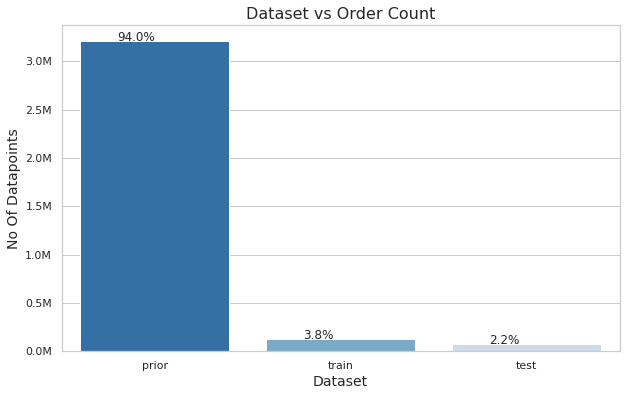

In [ ]:
# Reference :https://stackoverflow.com/questions/53747298/how-to-format-seaborn-matplotlib-axis-tick-labels-from-number-to-thousands-or-mi
eval_set = df_orders['eval_set'].value_counts().sort_values(ascending=False)
eval_set_df = eval_set.to_frame().reset_index().rename(columns={'index':'DataSet','eval_set':'Order Count'})
eval_set_df['% Order Count'] = np.round((eval_set_df['Order Count']/sum(eval_set_df['Order Count'])).values,3)*100
print(tabulate(eval_set_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
ax = sns.barplot(x = eval_set.index,y = eval_set.values,palette='Blues_r')
plt.title("Dataset vs Order Count",size=16)
plt.xlabel('Dataset',size=14)
plt.ylabel('No Of Datapoints',size=14)
total = sum(eval_set_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show()  

<b>Observation :</b> We have lots of data( 3.2 Million ) about users previous purchase history. We need to give predictions on the test set which is 75000 (2.2% of total data points) as mentioned in the problem description.

+---------------+---------------+-----------------+-----------------+-------------------+
|   Day Of Week |   Order Count |   % Order Count |   ReOrder Count |   % ReOrder Count |
|---------------+---------------+-----------------+-----------------+-------------------|
|             0 |        600905 |            17.6 |          494204 |              17.5 |
|             1 |        587478 |            17.2 |          492523 |              17.4 |
|             2 |        467260 |            13.7 |          386578 |              13.7 |
|             5 |        453368 |            13.3 |          374623 |              13.3 |
|             6 |        448761 |            13.1 |          368151 |              13   |
|             3 |        436972 |            12.8 |          359576 |              12.7 |
|             4 |        426339 |            12.5 |          350706 |              12.4 |
+---------------+---------------+-----------------+-----------------+-------------------+ 



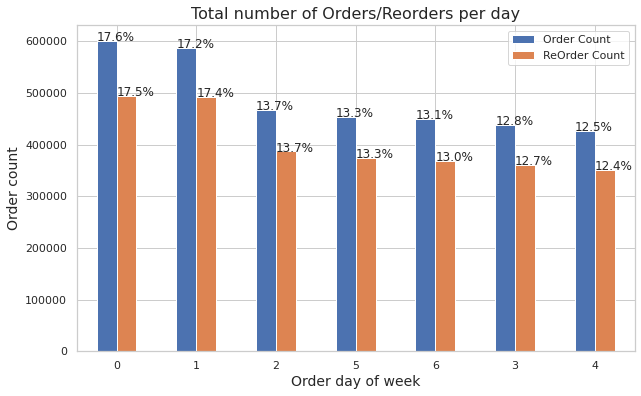

In [ ]:
order_dow = df_orders['order_dow'].value_counts().sort_values(ascending=False)
order_dow_df = order_dow.to_frame().reset_index().rename(columns={'index':'Day Of Week','order_dow':'Order Count'})
order_dow_df['% Order Count'] = np.round((order_dow_df['Order Count']/sum(order_dow_df['Order Count'])).values,3)*100
g = df_prior_final[df_prior_final['reordered']==1].groupby(['order_id','order_dow']).groups.keys()
reorder_dow =  pd.DataFrame(g,columns=['order_id','order_dow'])['order_dow'].value_counts().sort_values(ascending=False).reset_index().\
                                                                                          rename(columns={'index':'Day Of Week','order_dow':'ReOrder Count'})
order_dow_df = pd.merge(order_dow_df,reorder_dow,on='Day Of Week')                                                                                    
order_dow_df['% ReOrder Count'] =  np.round((order_dow_df['ReOrder Count']/sum(order_dow_df['ReOrder Count'])).values,3)*100
print(tabulate(order_dow_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = order_dow_df.set_index('Day Of Week')[['Order Count','ReOrder Count']].plot(kind='bar',figsize=(10,6),rot=0)
plt.title("Total number of Orders/Reorders per day",size=16)
plt.xlabel('Order day of week',size=14)
plt.ylabel('Order count',size=14)
total_order = sum(order_dow_df['Order Count'])
total_reorder = sum(order_dow_df['ReOrder Count'])
for p in ax.patches[:7]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+5))
for p in ax.patches[7:]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x(),p.get_height()+5))
plt.show()  

<b>Observation :</b> People are more likely to place orders on saturday(day 0) and sunday (day 1) than other days. Same trend follows for reorders also.


+---------------+---------------+-----------------+
|   Hour of day |   Order Count |   % Order Count |
|---------------+---------------+-----------------|
|            10 |        288418 |             8.4 |
|            11 |        284728 |             8.3 |
|            15 |        283639 |             8.3 |
|            14 |        283042 |             8.3 |
|            13 |        277999 |             8.1 |
|            12 |        272841 |             8   |
|            16 |        272553 |             8   |
|             9 |        257812 |             7.5 |
|            17 |        228795 |             6.7 |
|            18 |        182912 |             5.3 |
|             8 |        178201 |             5.2 |
|            19 |        140569 |             4.1 |
|            20 |        104292 |             3   |
|             7 |         91868 |             2.7 |
|            21 |         78109 |             2.3 |
|            22 |         61468 |             1.8 |
|           

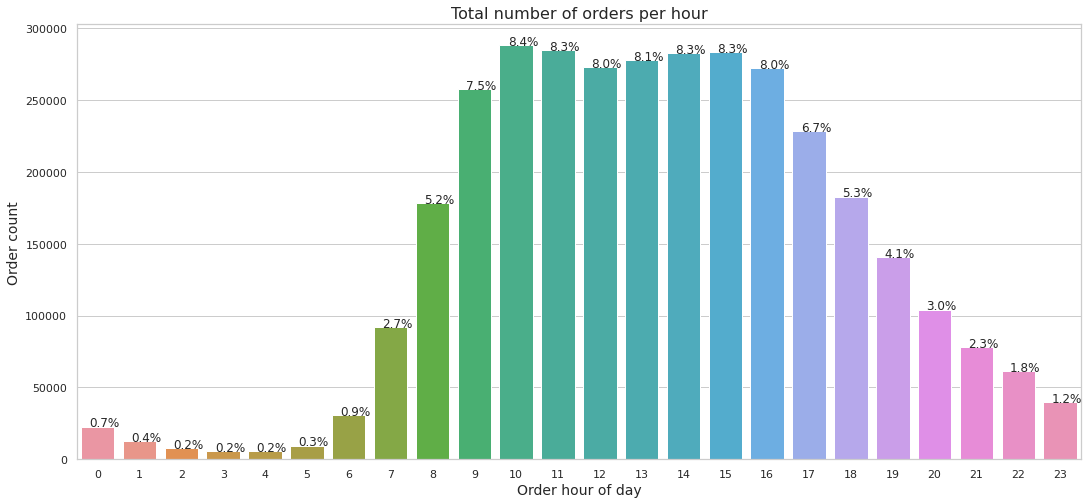

In [ ]:
order_hour_of_day = df_orders.fillna(0)['order_hour_of_day'].value_counts().sort_values(ascending=False)
order_hour_of_day_df = order_hour_of_day.to_frame().reset_index().rename(columns={'index':'Hour of day','order_hour_of_day':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
order_hour_of_day_df['% Order Count'] = np.round((order_hour_of_day_df['Order Count']/sum(order_hour_of_day_df['Order Count'])).values,3)*100
print(tabulate(order_hour_of_day_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = order_hour_of_day.index,y = order_hour_of_day.values)
plt.title("Total number of orders per hour",size=16)
plt.xlabel('Order hour of day',size=14)
plt.ylabel('Order count',size=14)
total = sum(order_hour_of_day_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Most people buy products between 7 AM to 8 PM. 10 AM is the peak hour when highest order is received.

+---------------+-----------------+-------------------+
|   Hour of day |   ReOrder Count |   % ReOrder Count |
|---------------+-----------------+-------------------|
|            10 |          239805 |               8.5 |
|            11 |          235078 |               8.3 |
|            15 |          233096 |               8.2 |
|            14 |          232858 |               8.2 |
|            13 |          228950 |               8.1 |
|            12 |          224027 |               7.9 |
|            16 |          223892 |               7.9 |
|             9 |          216067 |               7.6 |
|            17 |          187142 |               6.6 |
|             8 |          150623 |               5.3 |
|            18 |          149470 |               5.3 |
|            19 |          115000 |               4.1 |
|            20 |           85914 |               3   |
|             7 |           78237 |               2.8 |
|            21 |           64915 |             

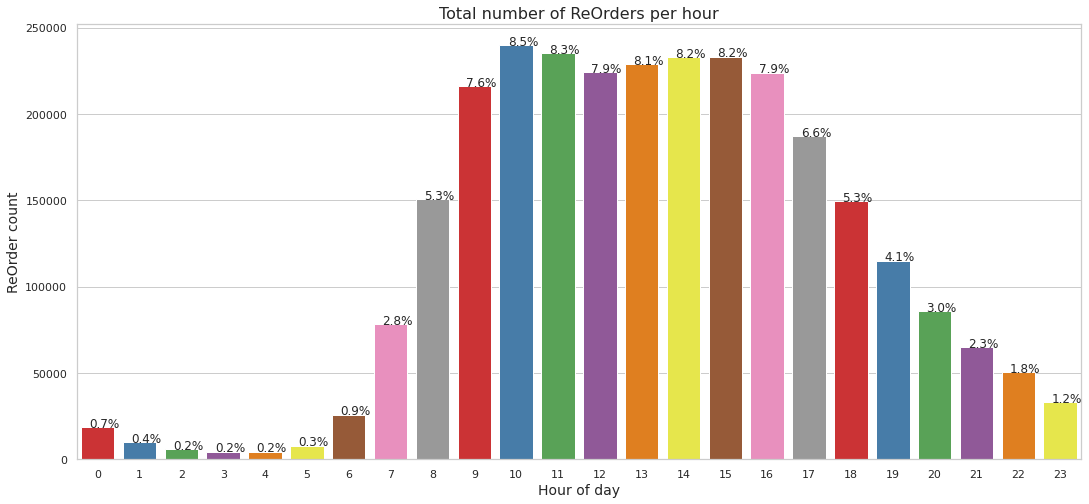

In [ ]:
#g = df_prior_final[df_prior_final['reordered']==1].groupby(['order_id','order_hour_of_day']).groups.keys()
reorder_hour_of_day_df  =  pd.DataFrame(g,columns=['order_id','order_hour_of_day'])['order_hour_of_day'].value_counts().sort_values(ascending=False)\
                                                                                  .reset_index().rename(columns={'index':'Hour of day','order_hour_of_day':'ReOrder Count'})
reorder_hour_of_day_df['% ReOrder Count'] =  np.round((reorder_hour_of_day_df['ReOrder Count']/sum(reorder_hour_of_day_df['ReOrder Count'])).values,3)*100
print(tabulate(reorder_hour_of_day_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = reorder_hour_of_day_df['Hour of day'],y = reorder_hour_of_day_df['ReOrder Count'],palette='Set1')
plt.title("Total number of ReOrders per hour",size=16)
plt.xlabel('Hour of day',size=14)
plt.ylabel('ReOrder count',size=14)
total = sum(reorder_hour_of_day_df['ReOrder Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Most people Reorder products between 7 AM to 8 PM. 10 AM is the peak hour when highest Reorder is received.

+--------+---------------+-----------------+
|   days |   Order Count |   % Order Count |
|--------+---------------+-----------------|
|     30 |        369323 |            10.8 |
|      7 |        320608 |             9.4 |
|      0 |        273964 |             8   |
|      6 |        240013 |             7   |
|      4 |        221696 |             6.5 |
|      3 |        217005 |             6.3 |
|      5 |        214503 |             6.3 |
|      2 |        193206 |             5.6 |
|      8 |        181717 |             5.3 |
|      1 |        145247 |             4.2 |
|      9 |        118188 |             3.5 |
|     14 |        100230 |             2.9 |
|     10 |         95186 |             2.8 |
|     13 |         83214 |             2.4 |
|     11 |         80970 |             2.4 |
|     12 |         76146 |             2.2 |
|     15 |         66579 |             1.9 |
|     16 |         46941 |             1.4 |
|     21 |         45470 |             1.3 |
|     17 |

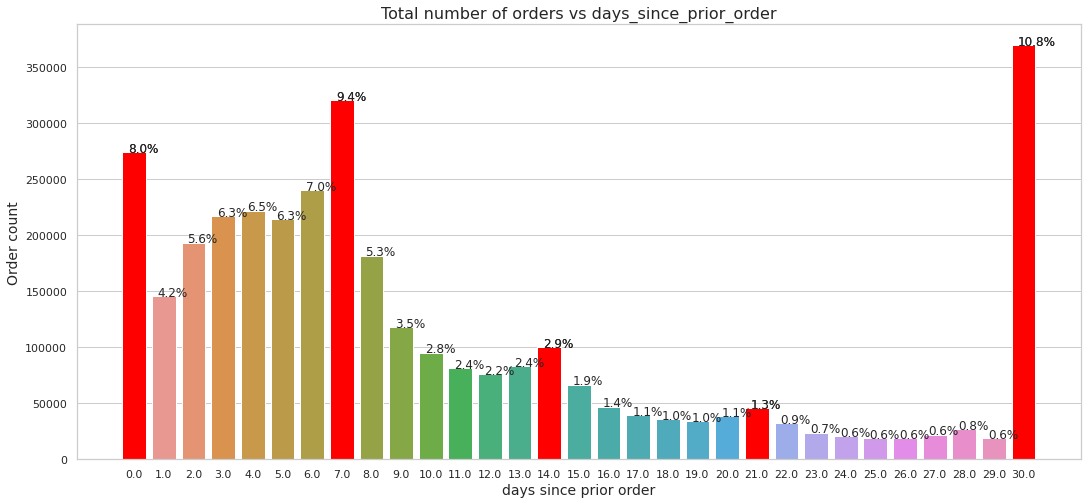

In [ ]:
#filling NaN values with 0 since days_since_prior_order will be 0 for users ordering their first product
days_since_prior_order = df_orders.fillna(0)['days_since_prior_order'].value_counts().sort_values(ascending=False)
days_since_prior_order_df =  days_since_prior_order.to_frame().reset_index().rename(columns={'index':'days','days_since_prior_order':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
days_since_prior_order_df['% Order Count'] = np.round(( days_since_prior_order_df['Order Count']/sum( days_since_prior_order_df['Order Count'])).values,3)*100
print(tabulate( days_since_prior_order_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =  days_since_prior_order.index,y =  days_since_prior_order.values)
spikes = [0,7,14,21,30]
plt.bar(x = spikes,height=days_since_prior_order[spikes].values,color='red')
plt.title("Total number of orders vs days_since_prior_order",size=16)
plt.xlabel('days since prior order',size=14)
plt.ylabel('Order count',size=14)
total = sum(days_since_prior_order_df['Order Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

<b>Observation :</b> Clearly People are likely to reorder products after 7th, 14th,21th,30th day after 0th day as we can clearly see spike at every 7th, 14th,21th,30th wrt its neiborhood days.This also makes sense as plople tend to buy products weekly and monthly basis <br> 30th day is the highest no of orders placed






+--------------------------+-----------------+-------------------+
|   days_since_prior_order |   ReOrder Count |   % ReOrder Count |
|--------------------------+-----------------+-------------------|
|                        7 |          296792 |              10.5 |
|                       30 |          267518 |               9.5 |
|                        6 |          221715 |               7.8 |
|                        4 |          204635 |               7.2 |
|                        3 |          199418 |               7.1 |
|                        5 |          197792 |               7   |
|                        2 |          174781 |               6.2 |
|                        8 |          166744 |               5.9 |
|                        1 |          125922 |               4.5 |
|                        9 |          107318 |               3.8 |
|                       14 |           88752 |               3.1 |
|                       10 |           86085 |               3

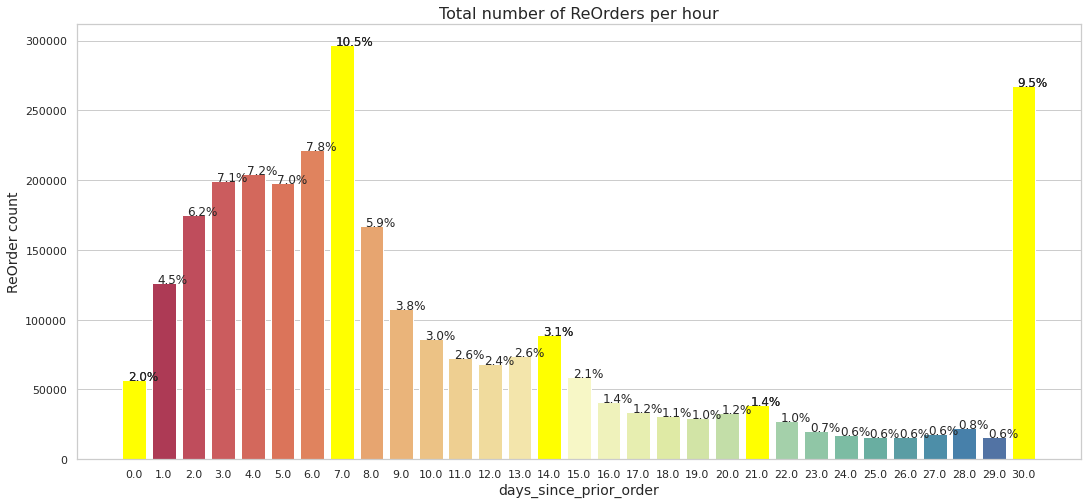

In [ ]:
g = df_prior_final[df_prior_final['reordered']==1].fillna(0).groupby(['order_id','days_since_prior_order']).groups.keys()
reorder_days_since_prior_order_df  =  pd.DataFrame(g,columns=['order_id','days_since_prior_order'])['days_since_prior_order'].value_counts().sort_values(ascending=False)\
                                                              .reset_index().rename(columns={'index':'days_since_prior_order','days_since_prior_order':'ReOrder Count'})
reorder_days_since_prior_order_df['% ReOrder Count'] =  np.round((reorder_days_since_prior_order_df['ReOrder Count']/sum(reorder_days_since_prior_order_df['ReOrder Count'])).values,3)*100
print(tabulate(reorder_days_since_prior_order_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x = reorder_days_since_prior_order_df['days_since_prior_order'],y = reorder_days_since_prior_order_df['ReOrder Count'],palette='Spectral')
spikes = [0,7,14,21,30]
plt.bar(x = spikes,height=reorder_days_since_prior_order_df[reorder_days_since_prior_order_df['days_since_prior_order'].\
                                                            isin(spikes)].sort_values('days_since_prior_order',axis=0)['ReOrder Count'],color='yellow')
plt.title("Total number of ReOrders per hour",size=16)
plt.xlabel('days_since_prior_order',size=14)
plt.ylabel('ReOrder count',size=14)
total = sum(reorder_days_since_prior_order_df['ReOrder Count'])
for p in ax.patches:
  ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
plt.show()  

Observation : Similar pattern follows for reorders same as order. Here
7th days_since_prior_order is the highest no of reorders placed

+--------------------+---------------+-----------------+
|   max_order_number |   Order Count |   % Order Count |
|--------------------+---------------+-----------------|
|                  4 |         23986 |          11.632 |
|                  5 |         19590 |           9.5   |
|                  6 |         16165 |           7.839 |
|                  7 |         13850 |           6.716 |
|                  8 |         11700 |           5.674 |
|                  9 |         10190 |           4.942 |
|                 10 |          9032 |           4.38  |
|                 11 |          7815 |           3.79  |
|                 12 |          6952 |           3.371 |
|                 13 |          6236 |           3.024 |
|                 14 |          5613 |           2.722 |
|                 15 |          5191 |           2.517 |
|                 16 |          4593 |           2.227 |
|                 17 |          4139 |           2.007 |
|                 18 |         

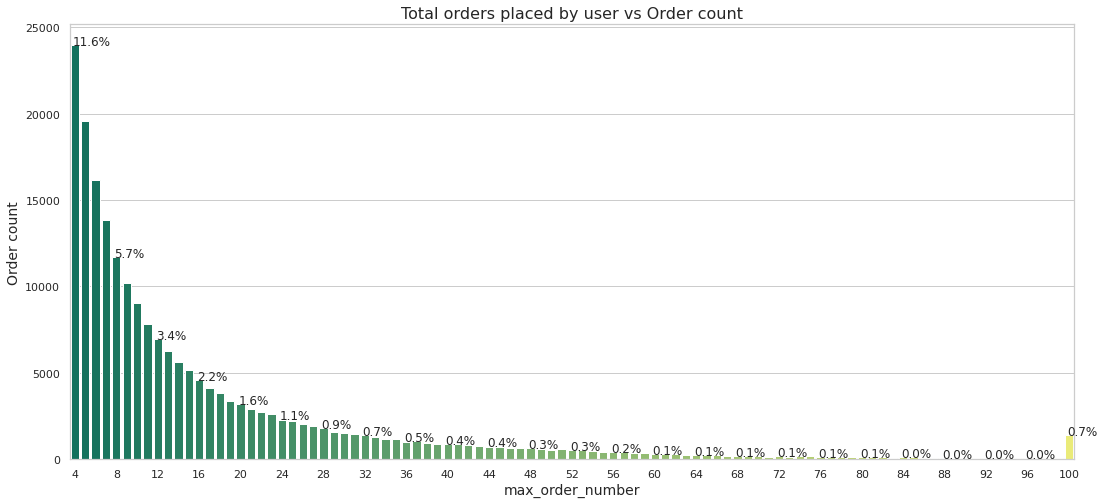

In [ ]:
max_order_number = df_orders.groupby('user_id')['order_number'].agg(np.max).reset_index().rename\
                                                    (columns={'order_number':'max_order_number'})['max_order_number'].value_counts().sort_values(ascending=False)
max_order_number_df =  max_order_number.to_frame().reset_index().rename(columns={'index':'max_order_number','max_order_number':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
max_order_number_df['% Order Count'] = np.round((  max_order_number_df['Order Count']/sum(  max_order_number_df['Order Count'])).values,5)*100
print(tabulate(  max_order_number_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =   max_order_number.index,y =   max_order_number.values,palette='summer')
plt.title("Total orders placed by user vs Order count",size=16)
plt.xlabel('max_order_number',size=14)
plt.ylabel('Order count',size=14)
total = sum( max_order_number_df['Order Count'])
i=0
for p in ax.patches:
  if i%4==0:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
  i+=1
locs, labels = plt.xticks()
plt.xticks(locs[::4], labels[::4]) 
#ax.set_xticklabels(labels, rotation=30,horizontalalignment='right')
plt.show()  

<b>Observation :</b> There is no user who has placed less than 4 oders and max order placed by users is 100

+---------------+---------------+-----------------+
|   bucket_size |   Order Count |   % Order Count |
|---------------+---------------+-----------------|
|             5 |        228330 |          7.1023 |
|             6 |        227675 |          7.0819 |
|             4 |        222081 |          6.9079 |
|             7 |        220006 |          6.8434 |
|             3 |        207027 |          6.4397 |
|             8 |        203374 |          6.326  |
|             2 |        186993 |          5.8165 |
|             9 |        184347 |          5.7342 |
|            10 |        165550 |          5.1495 |
|             1 |        156748 |          4.8757 |
|            11 |        147461 |          4.5868 |
|            12 |        131580 |          4.0929 |
|            13 |        116871 |          3.6353 |
|            14 |        103683 |          3.2251 |
|            15 |         91644 |          2.8506 |
|            16 |         81192 |          2.5255 |
|           

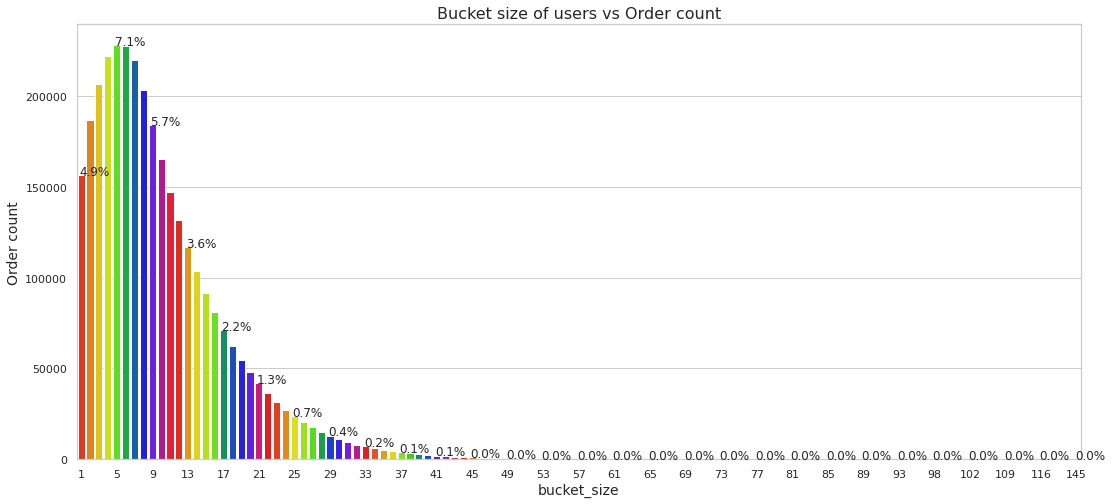

In [ ]:
bucket_size = df_prior_final.groupby('order_id')['add_to_cart_order'].agg(np.max).reset_index().rename\
                                                    (columns={'add_to_cart_order':'bucket_size'})['bucket_size'].value_counts().sort_values(ascending=False)
bucket_size_df = bucket_size.to_frame().reset_index().rename(columns={'index':'bucket_size','bucket_size':'Order Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
bucket_size_df['% Order Count'] = np.round(( bucket_size_df['Order Count']/sum( bucket_size_df['Order Count'])).values,6)*100
print(tabulate( bucket_size_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
plt.figure(figsize=(18,8))
ax = sns.barplot(x =  bucket_size.index,y =  bucket_size.values,palette='prism')
plt.title("Bucket size of users vs Order count",size=16)
plt.xlabel('bucket_size',size=14)
plt.ylabel('Order count',size=14)
total = sum(bucket_size_df['Order Count'])
for p in ax.patches[::4]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total),(p.get_x()+0.2,p.get_height()+5))
locs, labels = plt.xticks()
plt.xticks(locs[::4], labels[::4]) 
plt.show()                         

<b>Observation :</b> Bucket size of 5 and 6 are most frequent. Highest bucket size is 145 and there is only one user who has bought 145 products in an order

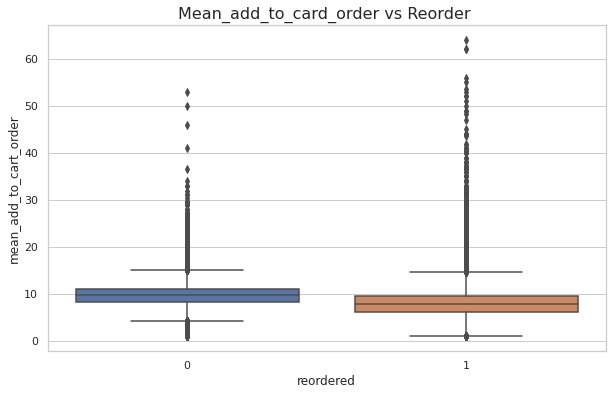

In [ ]:
mean_add_to_cart_order = df_prior_final[['product_id','add_to_cart_order','reordered']].groupby(['product_id','reordered'])['add_to_cart_order'].agg('mean')
mean_add_to_cart_order = mean_add_to_cart_order.reset_index().rename(columns ={'add_to_cart_order':'mean_add_to_cart_order'})
sns.set(style='whitegrid')
plt.figure(figsize=(10,6))
sns.boxplot(x='reordered',y='mean_add_to_cart_order',data=mean_add_to_cart_order)
plt.title("Mean_add_to_cart_order vs Reorder ",size=16)
plt.show()

<b>Observation :</b> Products that are not reordered have slightly high add_to_cart_order than products that are reordered. People are likely to put the reordered products in the cart first and they put not reordered products in the cart last.

		Word Cloud of Products Ordered



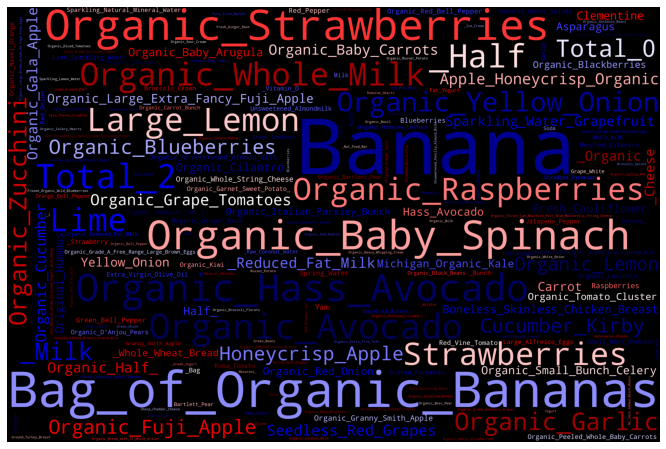


Top 100 products
+----------------------------------------------------------------+-----------------+-------------------+
| Product Name                                                   |   Product Count |   % Product Count |
|----------------------------------------------------------------+-----------------+-------------------|
| Banana                                                         |          472565 |               1.5 |
| Bag of Organic Bananas                                         |          379450 |               1.2 |
| Organic Strawberries                                           |          264683 |               0.8 |
| Organic Baby Spinach                                           |          241921 |               0.7 |
| Organic Hass Avocado                                           |          213584 |               0.7 |
| Organic Avocado                                                |          176815 |               0.5 |
| Large Lemon                        

In [ ]:
# Reference : https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
def plot_cloud(word_cloud):
  '''
    This function plots the world cloud 

    Attributes
    word_cloud : word cloud object

    Returns None
  '''
  plt.figure(figsize=(20,8))
  plt.imshow(word_cloud)
  plt.axis('off')
  plt.show()

products = df_prior_final['product_name'].to_list()
products = list(map(lambda x : '_'.join(str(x).split()),products))
products = ' '.join(products)
print("\t\tWord Cloud of Products Ordered\n")
word_cloud = WordCloud(width = 3000, height = 2000, random_state=1,background_color='black',colormap='seismic',collocations=False).generate(products)
plot_cloud(word_cloud)
print("\nTop 100 products")
product = df_prior_final['product_name'].value_counts().sort_values(ascending=False)
product_df =  product.to_frame().reset_index().rename(columns={'index':'Product Name','product_name':'Product Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
product_df['% Product Count'] = np.round(( product_df['Product Count']/sum( product_df['Product Count'])).values,3)*100
print(tabulate( product_df.head(100), headers='keys',showindex=False,tablefmt="psql"),"\n")

<b>Observation :</b> People are more likely to order orgainc products and fruits spcially organic fruits.Banana is the hishest ordered product.

		Word Cloud of Products ReOrdered



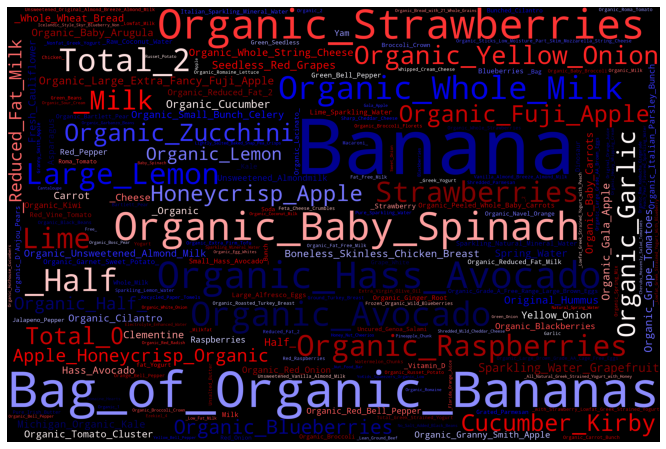


Top 100 ReOrdered products
+----------------------------------------------------------------+-----------------+-------------------+
| Product Name                                                   |   Product Count |   % Product Count |
|----------------------------------------------------------------+-----------------+-------------------|
| Banana                                                         |          398609 |               2.1 |
| Bag of Organic Bananas                                         |          315913 |               1.7 |
| Organic Strawberries                                           |          205845 |               1.1 |
| Organic Baby Spinach                                           |          186884 |               1   |
| Organic Hass Avocado                                           |          170131 |               0.9 |
| Organic Avocado                                                |          134044 |               0.7 |
| Organic Whole Milk       

In [ ]:
# Reference : https://towardsdatascience.com/simple-wordcloud-in-python-2ae54a9f58e5
def plot_cloud(word_cloud):
    '''
    This function plots the world cloud 

    Attributes
    word_cloud : word cloud object

    Returns None
    '''
    plt.figure(figsize=(20,8))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

products = df_prior_final[df_prior_final['reordered']==1]['product_name'].to_list()
products = list(map(lambda x : '_'.join(str(x).split()),products))
products = ' '.join(products)
print("\t\tWord Cloud of Products ReOrdered\n")
word_cloud = WordCloud(width = 3000, height = 2000, random_state=1,background_color='black',colormap='seismic',collocations=False).generate(products)
plot_cloud(word_cloud)
print("\nTop 100 ReOrdered products")
product = df_prior_final[df_prior_final['reordered']==1]['product_name'].value_counts().sort_values(ascending=False)
product_df =  product.to_frame().reset_index().rename(columns={'index':'Product Name','product_name':'Product Count'})#.assign(Order Count =  order_dow_df['Order Count']/)
product_df['% Product Count'] = np.round(( product_df['Product Count']/sum( product_df['Product Count'])).values,3)*100
print(tabulate( product_df.head(100), headers='keys',showindex=False,tablefmt="psql"),"\n")

<b>Observation :</b> People are more likely to Reorder orgainc products and fruits.Banana is the hishest reordered product.

+-------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------+
| Department Name   |   Ordered Product Count |   % Ordered Product Count |   ReOrdered Product Count |   % ReOrdered Product Count |   Product Count |   % Product Count |
|-------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------|
| produce           |                 9479291 |                      29.2 |                   6160710 |                        32.2 |            1684 |               3.4 |
| dairy eggs        |                 5414016 |                      16.7 |                   3627221 |                        19   |            3449 |               6.9 |
| snacks            |                 2887550 |                       8.9 |                   1657973 |                         8.7 |       

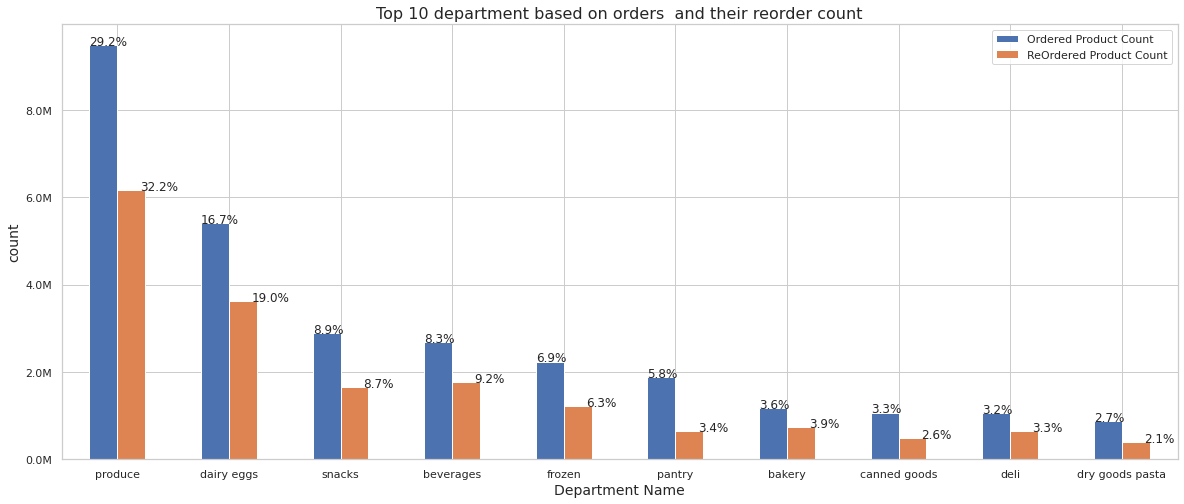

In [ ]:
department = df_prior_final['department'].value_counts()
department_df =  department.to_frame().reset_index().rename(columns={'index':'Department Name','department':'Ordered Product Count'})
department_df['% Ordered Product Count'] = np.round(( department_df['Ordered Product Count']/sum( department_df['Ordered Product Count'])).values,3)*100
reordered_department = df_prior_final[df_prior_final['reordered']==1]['department'].value_counts()
reordered_department_df =  reordered_department.to_frame().reset_index().rename(columns={'index':'Department Name','department':'ReOrdered Product Count'})
department_df = pd.merge(department_df,reordered_department_df,on='Department Name')
department_df['% ReOrdered Product Count'] = np.round(( department_df['ReOrdered Product Count']/sum( department_df['ReOrdered Product Count'])).values,3)*100
department_product_df = df_products_aisle_dep['department'].value_counts().reset_index().rename(columns={'index':'Department Name','department':'Product Count'})
department_df = pd.merge(department_df,department_product_df,on='Department Name')
department_df['% Product Count'] = np.round(( department_df['Product Count']/sum( department_df['Product Count'])).values,3)*100
print(tabulate( department_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = department_df.head(10).plot(x= 'Department Name',y=['Ordered Product Count','ReOrdered Product Count'],kind='bar',figsize=(20,8),rot=0)
plt.title("Top 10 department based on orders  and their reorder count",size=16)
plt.xlabel('Department Name',size=14)
plt.ylabel('count',size=14)
total_order = sum(department_df['Ordered Product Count'])
total_reorder = sum(department_df['ReOrdered Product Count'])
total_product = sum(department_df['Product Count'])
for p in ax.patches[:10]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+8))
for p in ax.patches[10:20]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x()+0.2,p.get_height()+5))
# for p in ax.patches[20:]:
#   ax.annotate('{:.1f}%'.format(100*p.get_height()/total_product),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show() 

<b>Observation :</b> Produce department has highest order and reorder.

+-------------------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------+
| aisle Name                    |   Ordered Product Count |   % Ordered Product Count |   ReOrdered Product Count |   % ReOrdered Product Count |   Product Count |   % Product Count |
|-------------------------------+-------------------------+---------------------------+---------------------------+-----------------------------+-----------------+-------------------|
| fresh fruits                  |                 3642188 |                      11.2 |                   2615469 |                        13.7 |             382 |               0.8 |
| fresh vegetables              |                 3418021 |                      10.5 |                   2032172 |                        10.6 |             569 |               1.1 |
| packaged vegetables fruits    |                 1765313 |                     

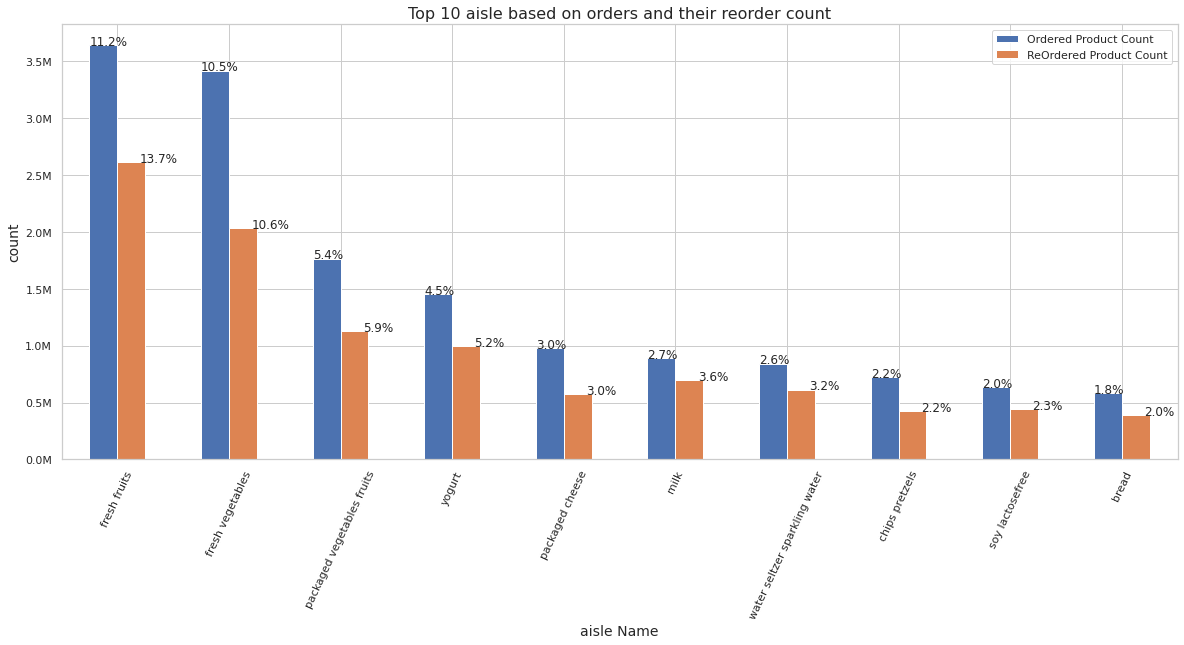

In [ ]:
aisle = df_prior_final['aisle'].value_counts()
aisle_df =  aisle.to_frame().reset_index().rename(columns={'index':'aisle Name','aisle':'Ordered Product Count'})
aisle_df['% Ordered Product Count'] = np.round(( aisle_df['Ordered Product Count']/sum( aisle_df['Ordered Product Count'])).values,3)*100
reordered_aisle = df_prior_final[df_prior_final['reordered']==1]['aisle'].value_counts()
reordered_aisle_df =  reordered_aisle.to_frame().reset_index().rename(columns={'index':'aisle Name','aisle':'ReOrdered Product Count'})
aisle_df = pd.merge(aisle_df,reordered_aisle_df,on='aisle Name')
aisle_df['% ReOrdered Product Count'] = np.round(( aisle_df['ReOrdered Product Count']/sum( aisle_df['ReOrdered Product Count'])).values,3)*100
aisle_product_df = df_products_aisle_dep['aisle'].value_counts().reset_index().rename(columns={'index':'aisle Name','aisle':'Product Count'})
aisle_df = pd.merge(aisle_df,aisle_product_df,on='aisle Name')
aisle_df['% Product Count'] = np.round(( aisle_df['Product Count']/sum( aisle_df['Product Count'])).values,3)*100
print(tabulate( aisle_df, headers='keys',showindex=False,tablefmt="psql"),"\n")
sns.set(style='whitegrid')
ax = aisle_df.head(10).plot(x= 'aisle Name',y=['Ordered Product Count','ReOrdered Product Count'],kind='bar',figsize=(20,8),rot=65)
plt.title("Top 10 aisle based on orders and their reorder count",size=16)
plt.xlabel('aisle Name',size=14)
plt.ylabel('count',size=14)
total_order = sum(aisle_df['Ordered Product Count'])
total_reorder = sum(aisle_df['ReOrdered Product Count'])
total_product = sum(aisle_df['Product Count'])
for p in ax.patches[:10]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_order),(p.get_x(),p.get_height()+8))
for p in ax.patches[10:20]:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total_reorder),(p.get_x()+0.2,p.get_height()+5))
ylabels = list(map(lambda x : '{:.1f}'.format(x/10**6) + 'M', list(ax.get_yticks())))
ax.set_yticklabels(ylabels)
plt.show() 

<b>Observation :</b> Fresh fruit and fresh vegetables have highest order and reorders. Whic is quite natural as people buy fruits and vegetables regulat basis

In [ ]:
# Reference https://plotly.com/python/treemaps/
dep_aisle = pd.merge(aisle_df[['aisle Name','ReOrdered Product Count']],df_products_aisle_dep[['aisle',	'department']].drop_duplicates(),left_on=['aisle Name'],right_on=['aisle'])
fig = px.treemap(dep_aisle,path = ['department','aisle Name'],values ='ReOrdered Product Count',width=1400, height=700
                                                        )
fig.update_layout(title_text='Contribution of each department and aisle to Total Reorders', title_x=0.5)
fig.show()

<b>Observation :</b> In the above treemap we have shown contibution of Department and its aisle to total reorders. Produce has hisghest reorders and under produce fresh fruits and vegetables are the top aisle in terms of reorder.

# Starting Feature Engineering

In [5]:
# We are adding features
#                        1. date : Inverse cumulative sum of days_since_prior_order means latest orders having low date value 
#                        2. order_number_reverse  : first order is N, last is 1
def add_fe_to_orders(group):
    group["date"] = group.iloc[::-1]['days_since_prior_order'].cumsum()[::-1].shift(-1).fillna(0)
    max_group = group["order_number"].max()
    group["order_number_reverse"] = max_group - group["order_number"]
    return group
orders = df_orders.groupby("user_id").\
       apply(add_fe_to_orders)
df_prior_final = df_prior_final.merge(orders[['date','order_number_reverse','order_id']],on='order_id',how='left')

In [6]:
# order_size : basket size in each order
# add_to_cart_order_inverted : Inverse position of the product in the cart
# add_to_cart_order_relative :  Relative position of the product in the cart
# last_basket_size : basket size previous each order
order_stat = df_prior_final.groupby('order_id').agg({'order_id': 'size'}) \
            .rename(columns={'order_id': 'order_size'}).reset_index()
df_prior_final = pd.merge(df_prior_final, order_stat, on='order_id')
df_prior_final['add_to_cart_order_inverted'] = df_prior_final.order_size - df_prior_final.add_to_cart_order
df_prior_final['add_to_cart_order_relative'] = df_prior_final.add_to_cart_order / df_prior_final.order_size
del order_stat

# last_basket_size to orders 
last_basket_size = df_prior_final.groupby(["user_id", "order_number_reverse"]).size(). \
    rename("last_basket_size").reset_index()
last_basket_size["order_number_reverse"] = last_basket_size["order_number_reverse"] - 1

df_prior_final = pd.merge(df_prior_final, last_basket_size, how="left", on=["user_id", "order_number_reverse"])

del last_basket_size
df_prior_final.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department,date,order_number_reverse,order_size,add_to_cart_order_inverted,add_to_cart_order_relative,last_basket_size
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs,153.0,6,9,8,0.111111,12.0
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce,153.0,6,9,7,0.222222,12.0
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry,153.0,6,9,6,0.333333,12.0
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry,153.0,6,9,5,0.444444,12.0
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry,153.0,6,9,4,0.555556,12.0


# User features

In [11]:
# Here we will calculate user based features such as 
#                                                   1. Number of orders per User
#                                                   2. How frequent a user has reordered products
#                                                   3. average days between user's purchases
#                                                   4. standard deviation in user's days_since_prior_order
#                                                   5. Day of the week the users orders the most
#                                                   6. hour of day the user has ordered most.
#                                                   7. Total products bought per user 
#                                                   8. Total unique products ordered
user= df_prior_final.groupby('user_id').agg({'order_number' : 'max',
                                            'reordered' : 'mean',
                                            'days_since_prior_order' : ['mean','std'],
                                             'order_dow' : lambda x : stats.mode(x)[0],
                                             'order_hour_of_day' : lambda x : stats.mode(x)[0],
                                             'order_id' : 'count',
                                             'product_id' : lambda x : x.unique().shape[0]}).reset_index()
user.columns = ['user_id','u_total_orders','u_reordered_ratio','u_average_days_between_orders','u_days_between_orders_std','u_dow_most_orders','u_hod_most_orders',
                'u_total_items_bought','u_total_unique_prod']
user.head()

,user_id,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_days_between_orders_std,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_total_unique_prod
0,1,10,0.694915,20.259259,9.304463,4,7,59,18
1,2,14,0.476923,15.967033,9.119769,2,9,195,102
2,3,12,0.625000,11.487179,4.869048,0,16,88,33
3,4,5,0.055556,15.357143,8.580901,4,15,18,17
4,5,4,0.378378,14.500000,4.263801,3,18,37,23


In [12]:
# User's avg basket size
basket_size_per_order = df_prior_final.groupby(by=['user_id', 'order_id'])['product_id'].aggregate('count').to_frame('basket_size_per_order').reset_index()
avg_basket_size = basket_size_per_order.groupby(by=['user_id']).agg({'basket_size_per_order' : ['sum','mean','std']}).reset_index()
#deleting the avg_basket_size dataframe
avg_basket_size.columns = ['user_id','u_basket_sum','u_avg_basket_size','u_basket_std']
del [basket_size_per_order]
gc.collect()
avg_basket_size.head()

,user_id,u_basket_sum,u_avg_basket_size,u_basket_std
0,1,59,5.900000,1.523884
1,2,195,13.928571,5.717238
2,3,88,7.333333,2.103388
3,4,18,3.600000,2.073644
4,5,37,9.250000,3.095696


In [13]:
# combining both user and avg_basket_size DF based on user_id
# u_date_inscription : max date for each user excluding last order
user = user.merge(avg_basket_size,on='user_id', how='left')
users_fe = orders.query("order_number_reverse != 0").groupby("user_id").agg({'date': 'max'}).rename(columns={'date' :'u_date_inscription'}).reset_index()
user = user.merge(users_fe,on='user_id', how='left')
user.head()

,user_id,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_days_between_orders_std,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_total_unique_prod,u_basket_sum,u_avg_basket_size,u_basket_std,u_date_inscription
0,1,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.900000,1.523884,190.0
1,2,14,0.476923,15.967033,9.119769,2,9,195,102,195,13.928571,5.717238,228.0
2,3,12,0.625000,11.487179,4.869048,0,16,88,33,88,7.333333,2.103388,144.0
3,4,5,0.055556,15.357143,8.580901,4,15,18,17,18,3.600000,2.073644,85.0
4,5,4,0.378378,14.500000,4.263801,3,18,37,23,37,9.250000,3.095696,46.0


# product features

In [14]:
# Here we will calculate product based features such as 
#                                                       1. Number of purchases for each product
#                                                       2. How frequent a product has been  reordered
#                                                       3. Mean add to cart for each product.
#                                                       4. user base for each product
#                                                       5. mean order_number
#                                                       6. mean order_number_reverse
#                                                       7. mean date 
                                                            
product = df_prior_final.groupby('product_id').agg({'order_id' : 'count',
                                                'reordered' : 'mean',
                                                'add_to_cart_order': 'mean',
                                                'user_id' : lambda x : x.unique().shape[0],
                                                'order_number' : "mean",
                                                'order_number_reverse' : "mean",
                                                 'date' : "mean"
                                                }).reset_index()
product.columns = ['product_id','p_total_purchases','p_reorder_ratio','p_avg_cart_position','p_unique_user_count',"p_recency_order",'p_recency_order_rev','p_recency_date']
product = product.merge(df_products_aisle_dep[['product_id','product_name','aisle_id','department_id']],on='product_id',how='left')
product.head()

,product_id,p_total_purchases,p_reorder_ratio,p_avg_cart_position,p_unique_user_count,p_recency_order,p_recency_order_rev,p_recency_date,product_name,aisle_id,department_id
0,1,1852,0.613391,5.801836,716,19.397408,17.238121,124.236501,Chocolate Sandwich Cookies,61,19
1,2,90,0.133333,9.888889,78,25.666667,15.133333,97.166667,All-Seasons Salt,104,13
2,3,277,0.732852,6.415162,74,17.342960,26.465704,163.555957,Robust Golden Unsweetened Oolong Tea,94,7
3,4,329,0.446809,9.507599,182,9.027356,10.167173,126.197568,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,15,0.600000,6.466667,6,8.933333,12.600000,177.800000,Green Chile Anytime Sauce,5,13


In [15]:
# Product trend : we are taking last 2 orders across user's and calculating product reorder trend
# p_trend_rt :  no of times product ordered in last order/ no of times product ordered in 2nd last order across user's
# p_trend_diff : no of times product ordered in last order minus no of times product ordered in 2nd last order across user's
products_trend = df_prior_final.query("order_number_reverse < 3"). \
    groupby(["product_id", "order_number_reverse"]).size(). \
    rename("p_size").reset_index()

products_trend["p_trend_rt"] = products_trend["p_size"] / products_trend["p_size"].shift(-1)
products_trend["p_trend_diff"] = products_trend["p_size"] - products_trend["p_size"].shift(-1)

# If the product is not ordered in 2nd last order then set p_trend_rt as np.nan
cond = products_trend["product_id"] != products_trend["product_id"].shift(-1)
products_trend.loc[cond, "p_trend_rt"] = np.nan
products_trend.loc[cond, "p_trend_diff"] = np.nan
products_trend = products_trend.query("order_number_reverse == 1").drop("order_number_reverse", 1)
product = pd.merge(product, products_trend, how="left", on="product_id")
del cond, products_trend

In [16]:
# p_freq_days : Mean days before the product is reordered
# p_freq_order : Mean number of orders before the product is reordered
product_freq = df_prior_final.copy()
product_freq = product_freq.sort_values(["user_id", "product_id", "order_number"])

product_freq["p_freq_days"] = product_freq["date"].shift() - product_freq["date"]
product_freq["p_freq_order"] = product_freq["order_number"] - product_freq["order_number"].shift()
product_freq = product_freq.query("reordered == 1")

product_freq = product_freq.groupby("product_id"). \
                                agg({'p_freq_days':  "mean", 
                                        'p_freq_order': "mean"}).reset_index()
                                    
product = pd.merge(product, product_freq, how="left", on="product_id")

del product_freq
product.head()

,product_id,p_total_purchases,p_reorder_ratio,p_avg_cart_position,p_unique_user_count,p_recency_order,p_recency_order_rev,p_recency_date,product_name,aisle_id,department_id,p_size,p_trend_rt,p_trend_diff,p_freq_days,p_freq_order
0,1,1852,0.613391,5.801836,716,19.397408,17.238121,124.236501,Chocolate Sandwich Cookies,61,19,106.0,0.921739,-9.0,27.961268,3.599472
1,2,90,0.133333,9.888889,78,25.666667,15.133333,97.166667,All-Seasons Salt,104,13,5.0,0.625000,-3.0,50.166667,10.500000
2,3,277,0.732852,6.415162,74,17.342960,26.465704,163.555957,Robust Golden Unsweetened Oolong Tea,94,7,8.0,0.800000,-2.0,19.369458,2.655172
3,4,329,0.446809,9.507599,182,9.027356,10.167173,126.197568,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,37.0,1.233333,7.0,31.707483,2.598639
4,5,15,0.600000,6.466667,6,8.933333,12.600000,177.800000,Green Chile Anytime Sauce,5,13,NaN,NaN,NaN,34.888889,2.777778


# User X product Features

In [17]:
# Here the idea is For an user with 5 orders (NA means the product wasn’t bought yet)
# 0 0 0 0 1 = 1/2**5 = 0.03125 a product bought the first time and never purchased again
# 1 1 NA NA NA = 1/2**1 + 1/2**2 = 0.75 a product purchased the last two times
# 1 0 0 1 NA = 1/2**1 + 1/2**4 = 0.5625
# It helps to focus on a product that user is recently started reordering 
df_prior_final["uxp_date_strike"] = 1 / 2 ** (df_prior_final["date"] / 7)
df_prior_final["uxp_order_strike"] = 1 / 2 ** (df_prior_final["order_number_reverse"])

# User X product Features

In [18]:
# Here we will calculate user x product based features such as 
#                                                             1. number of times a user have bough a product
#                                                             2. How frequent a user has reordered a particular product
#                                                             3. user's mean add_to_cart_order for a paricular product
#                                                             4. user's mean add_to_cart_order_relative for a paricular product
#                                                             5. user's mean add_to_cart_order_inverted for a paricular product
#                                                             6. user's first and last order_number for a particular product
#                                                             6. user's first and last date for a particular product
uxp = df_prior_final.groupby(['user_id', 'product_id']).agg({'order_id' : 'count',
                                                             'reordered' : 'mean',
                                                             'add_to_cart_order': 'mean',
                                                             'add_to_cart_order_relative' : 'mean',
                                                             'add_to_cart_order_inverted' :  'mean',
                                                             'order_number_reverse' : ['min','max'],
                                                             'date' :  ['min','max'],
                                                            'uxp_date_strike' : 'sum',
                                                             'uxp_order_strike' : 'sum'
                                                             }).reset_index()
uxp.columns = ['user_id','product_id','uxp_total_bought','uxp_reorder_ratio','uxp_avg_cart_position',
               'uxp_add_to_cart_order_relative_mean','uxp_add_to_cart_order_inverted_mean','uxp_last_order_number','uxp_first_order_number',
               'up_last_order_date','up_first_order_date','uxp_date_strike','uxp_order_strike']
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_avg_cart_position,uxp_add_to_cart_order_relative_mean,uxp_add_to_cart_order_inverted_mean,uxp_last_order_number,uxp_first_order_number,up_last_order_date,up_first_order_date,uxp_date_strike,uxp_order_strike
0,1,196,10,0.900000,1.400000,0.245278,4.500000,1,10,14.0,190.0,0.279354,0.999023
1,1,10258,9,0.888889,3.333333,0.562037,2.666667,1,9,14.0,175.0,0.279354,0.998047
2,1,10326,1,0.000000,5.000000,0.625000,3.000000,6,6,97.0,97.0,0.000067,0.015625
3,1,12427,10,0.900000,3.300000,0.541667,2.600000,1,10,14.0,190.0,0.279354,0.999023
4,1,13032,3,0.666667,6.333333,0.962963,0.333333,1,9,14.0,175.0,0.253204,0.564453


In [ ]:
u_tot_active_prod : Number of products that user has reordered 
u_reorder_ratio_bool : mean reorder value across products
p_tot_active_usr : Number of users for a product that has been reordered 
p_reorder_ratio_bool : mean reorder value across usres for a particular product

In [19]:
# u_tot_active_prod : Number of products that user has reordered 
# u_reorder_ratio_bool : mean reorder value across products
# p_tot_active_usr : Number of users for a product that has been reordered 
# p_reorder_ratio_bool : mean reorder value across usres for a particular product

uxp["bool_reordered"] = (uxp["uxp_total_bought"] > 1).astype("int")
users_fe1 = uxp.groupby('user_id')["bool_reordered"].agg(["mean", "size"]).reset_index()\
                                        .rename(index=str, columns={"mean": "u_reorder_ratio_bool", "size": "u_tot_active_prod"})
# Merging back to user feature DF
user = pd.merge(user, users_fe1, on="user_id",how="left")
product_fe1 = uxp.groupby('product_id')["bool_reordered"].agg(["mean", "size"]).reset_index()\
                                        .rename(index=str, columns={"mean": "p_reorder_ratio_bool", "size": "p_tot_active_usr"})
product = pd.merge(product, product_fe1, on="product_id",how="left")
uxp.drop(['bool_reordered'],axis=1,inplace=True)
del users_fe1,product_fe1

In [20]:
#product bought by users in the last_five orders. This will capture recency of user-product
df_prior_final['order_number_back'] = df_prior_final.groupby('user_id')['order_number'].transform(max) - df_prior_final.order_number + 1 
last_five = df_prior_final[df_prior_final.order_number_back <= 5]
last_five = last_five.groupby(['user_id','product_id'])[['order_id']].count()
last_five.columns = ['uxp_bought_last5']
uxp = uxp.merge(last_five , on=['user_id', 'product_id'], how='left')
del [last_five]
gc.collect()
#There are productes that were not ordered in last 5 orders. So uxp_bought_last5 will be 0 for them
#filling the uxp_bought_last5 NAN values with 0.
uxp.fillna(0, inplace=True)
uxp.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_avg_cart_position,uxp_add_to_cart_order_relative_mean,uxp_add_to_cart_order_inverted_mean,uxp_last_order_number,uxp_first_order_number,up_last_order_date,up_first_order_date,uxp_date_strike,uxp_order_strike,uxp_bought_last5
0,1,196,10,0.900000,1.400000,0.245278,4.500000,1,10,14.0,190.0,0.279354,0.999023,5.0
1,1,10258,9,0.888889,3.333333,0.562037,2.666667,1,9,14.0,175.0,0.279354,0.998047,5.0
2,1,10326,1,0.000000,5.000000,0.625000,3.000000,6,6,97.0,97.0,0.000067,0.015625,0.0
3,1,12427,10,0.900000,3.300000,0.541667,2.600000,1,10,14.0,190.0,0.279354,0.999023,5.0
4,1,13032,3,0.666667,6.333333,0.962963,0.333333,1,9,14.0,175.0,0.253204,0.564453,2.0


# Aisle features

In [21]:
#             1.Number of purchases for each aisle
#             2.How frequent a aisle has been reordered
#             3.Mean add to cart for each aisle.
#             4.user base for each aisle 
aisle = df_prior_final.groupby('aisle_id').agg({'order_id' : 'count',
                                                'reordered' : 'mean',
                                                'add_to_cart_order': 'mean',
                                                'user_id' : lambda x : x.unique().shape[0]
                                                }).reset_index()
aisle.columns = ['aisle_id','a_total_purchases','a_reorder_ratio','a_avg_cart_position','a_unique_user_count']
aisle.head()

,aisle_id,a_total_purchases,a_reorder_ratio,a_avg_cart_position,a_unique_user_count
0,1,71928,0.596597,8.167640,20711
1,2,82491,0.489326,9.275497,31222
2,3,456386,0.598007,9.571935,63592
3,4,200687,0.489533,10.161450,53892
4,5,62510,0.280627,10.297600,32312


# User X Aisle Features

In [22]:
# uxa_unique_products_ratio : Ratio of products purchased by the user in this aisle
uxa = df_prior_final.groupby(['user_id', 'aisle_id']).agg({'product_id' : 'nunique',
                                                            'order_id': 'size' }).reset_index()
uxa.columns = ['user_id','aisle_id','uxa_total_unque_products','uxa_total_ordered']
uxa.head()
uxa= pd.merge(uxa, user[["user_id", "u_tot_active_prod"]], how="left", on="user_id")
uxa["uxa_unique_products_ratio"] = uxa["uxa_total_unique_products"] / uxa["u_tot_active_prod"]
uxa= uxa.drop("u_tot_active_prod", axis=1)
uxa

,user_id,aisle_id,uxa_total_unique_products,uxa_total_ordered,uxa_unique_products_ratio
0,1,21,1,8,0.055556
1,1,23,2,12,0.111111
2,1,24,4,5,0.222222
3,1,45,1,1,0.055556
4,1,53,1,2,0.055556
...,...,...,...,...,...
5729244,206209,120,3,3,0.044118
5729245,206209,121,4,6,0.058824
5729246,206209,123,3,5,0.044118
5729247,206209,130,2,3,0.029412


In [23]:
# a_tot_active_user : Number of users for a aisle that has been reordered 
# a_reorder_ratio_bool : mean reorder value across usres for a particular aisle
uxa["uxa_bool_reordered"] = (uxa["uxa_total_ordered"] > 1).astype("int")

aisles_fe = uxa.groupby('aisle_id')["uxa_bool_reordered"]. \
    agg(["mean", "size"]).reset_index(). \
    rename(index=str, columns={"mean": "a_reorder_ratio_bool", "size": "a_tot_active_user"})

aisles = pd.merge(aisle, aisles_fe, how="left", on="aisle_id")
uxa.drop(['uxa_bool_reordered'],axis=1,inplace=True)
del aisles_fe
aisles.head()

,aisle_id,a_total_purchases,a_reorder_ratio,a_avg_cart_position,a_unique_user_count,a_reorder_ratio_bool,a_tot_active_user
0,1,71928,0.596597,8.167640,20711,0.525566,20711
1,2,82491,0.489326,9.275497,31222,0.478349,31222
2,3,456386,0.598007,9.571935,63592,0.733834,63592
3,4,200687,0.489533,10.161450,53892,0.625622,53892
4,5,62510,0.280627,10.297600,32312,0.391650,32312


# Department

In [24]:
#             1.Number of purchases for each department
#             2.How frequent a department has been reordered
#             3.Mean add to cart for each department.
#             4.user base for each department 
department = df_prior_final.groupby('department_id').agg({'order_id' : 'count',
                                                'reordered' : 'mean',
                                                'add_to_cart_order': 'mean',
                                                'user_id' : lambda x : x.unique().shape[0]
                                                }).reset_index()
department.columns = ['department_id','d_total_purchases','d_reorder_ratio','d_avg_cart_position','d_unique_user_count']
department.head()

,department_id,d_total_purchases,d_reorder_ratio,d_avg_cart_position,d_unique_user_count
0,1,2236432,0.541885,8.996414,163233
1,2,36291,0.407980,8.277645,17875
2,3,1176787,0.628141,8.084397,140612
3,4,9479291,0.649913,8.022875,193237
4,5,153696,0.569924,5.428346,15798


In [25]:
# uxa_unique_products_ratio : Ratio of products purchased by the user in this department
uxd= df_prior_final.groupby(['user_id', 'department_id']).agg({'product_id' : 'nunique',
                                                            'order_id': 'size' }).reset_index()
uxd.columns = ['user_id','department_id','uxd_total_unique_products','uxd_total_ordered']
uxd.head()
uxd= pd.merge(uxd, user[["user_id", "u_tot_active_prod"]], how="left", on="user_id")
uxd["uxd_unique_products_ratio"] = uxd["uxd_total_unique_products"] / uxd["u_tot_active_prod"]
uxd= uxd.drop("u_tot_active_prod", axis=1)
uxd.head()

,user_id,department_id,uxd_total_unique_products,uxd_total_ordered,uxd_unique_products_ratio
0,1,4,4,5,0.222222
1,1,7,2,13,0.111111
2,1,13,1,1,0.055556
3,1,14,1,3,0.055556
4,1,16,5,13,0.277778


In [26]:
# a_tot_active_user : Number of users for a department that has been reordered 
# a_reorder_ratio_bool : mean reorder value across usres for a particular department
uxd["uxd_bool_reordered"] = (uxd["uxd_total_ordered"] > 1).astype("int")

departments_fe = uxd.groupby('department_id')["uxd_bool_reordered"]. \
    agg(["mean", "size"]).reset_index(). \
    rename(index=str, columns={"mean": "a_reorder_ratio_bool", "size": "a_tot_active_user"})

department = pd.merge(department, departments_fe, how="left", on="department_id")
uxd.drop(['uxd_bool_reordered'],axis=1,inplace=True)
del departments_fe
department.head()

,department_id,d_total_purchases,d_reorder_ratio,d_avg_cart_position,d_unique_user_count,a_reorder_ratio_bool,a_tot_active_user
0,1,2236432,0.541885,8.996414,163233,0.876520,163233
1,2,36291,0.407980,8.277645,17875,0.352280,17875
2,3,1176787,0.628141,8.084397,140612,0.800508,140612
3,4,9479291,0.649913,8.022875,193237,0.966326,193237
4,5,153696,0.569924,5.428346,15798,0.769781,15798


In [27]:
# Merging features
uxa = uxa.merge(aisle,on='aisle_id')
uxd = uxd.merge(department,on='department_id')
del aisle,department

In [28]:
# Now we are going to Merge uxp with user , product,uxa,uxd DataFrame so that we can have user's global features(user), products's global features(product)
# and user's purchase behavior towards the product(uxp) everthing at same place
data = uxp.merge(user, on='user_id', how='left').merge(product, on='product_id', how='left')\
            .merge(uxa,on=['user_id', 'aisle_id'],how='left').merge(uxd,on=['user_id', 'department_id'],how='left')
del user, product, uxp,uxa,uxd
gc.collect()

40

In [2]:
data = pd.read_pickle("data.pkl")

# Word2Vec on products

The objective of using this approach is to idenify products that are bought together or products that are similar. In each order user orders a number of products. We are using word to vector since it focuses on neighborhood words that comes in same context and tries to represent words as vectors. We can use each order as a sentence and each product as a word.

In [4]:
products = df_products.set_index('product_id')
df_prior_final['product_id'] = df_prior_final['product_id'].astype(str)
df_train_final['product_id'] = df_train_final['product_id'].astype(str)

In [5]:
train_products = df_train_final.groupby("order_id").apply(lambda order: order['product_id'].tolist())
prior_products = df_prior_final.groupby("order_id").apply(lambda order: order['product_id'].tolist())

In [6]:
sentences = prior_products.append(train_products)
longest = np.max(sentences.apply(len))
# preparing data in list of list format that Gensim expects
sentences = sentences.values
print(longest)

145


In [7]:
# We have used window=longest since if we use smaller window then products that are outside the window
# will not be considered in same context though they are added to cart agaist same order. That's why
# we are setting windsize large enough to accomodate all products agaist same order
model = gensim.models.Word2Vec(sentences, size=100, window=longest, min_count=2, workers=4)

<b>Visualization:</b> <br>
Once the model has learnt the vector embeeding we will try to visulize products by projecting vector
embeeding in 2D using PCA

In [9]:
vocab = list(model.wv.vocab.keys())
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

In [18]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


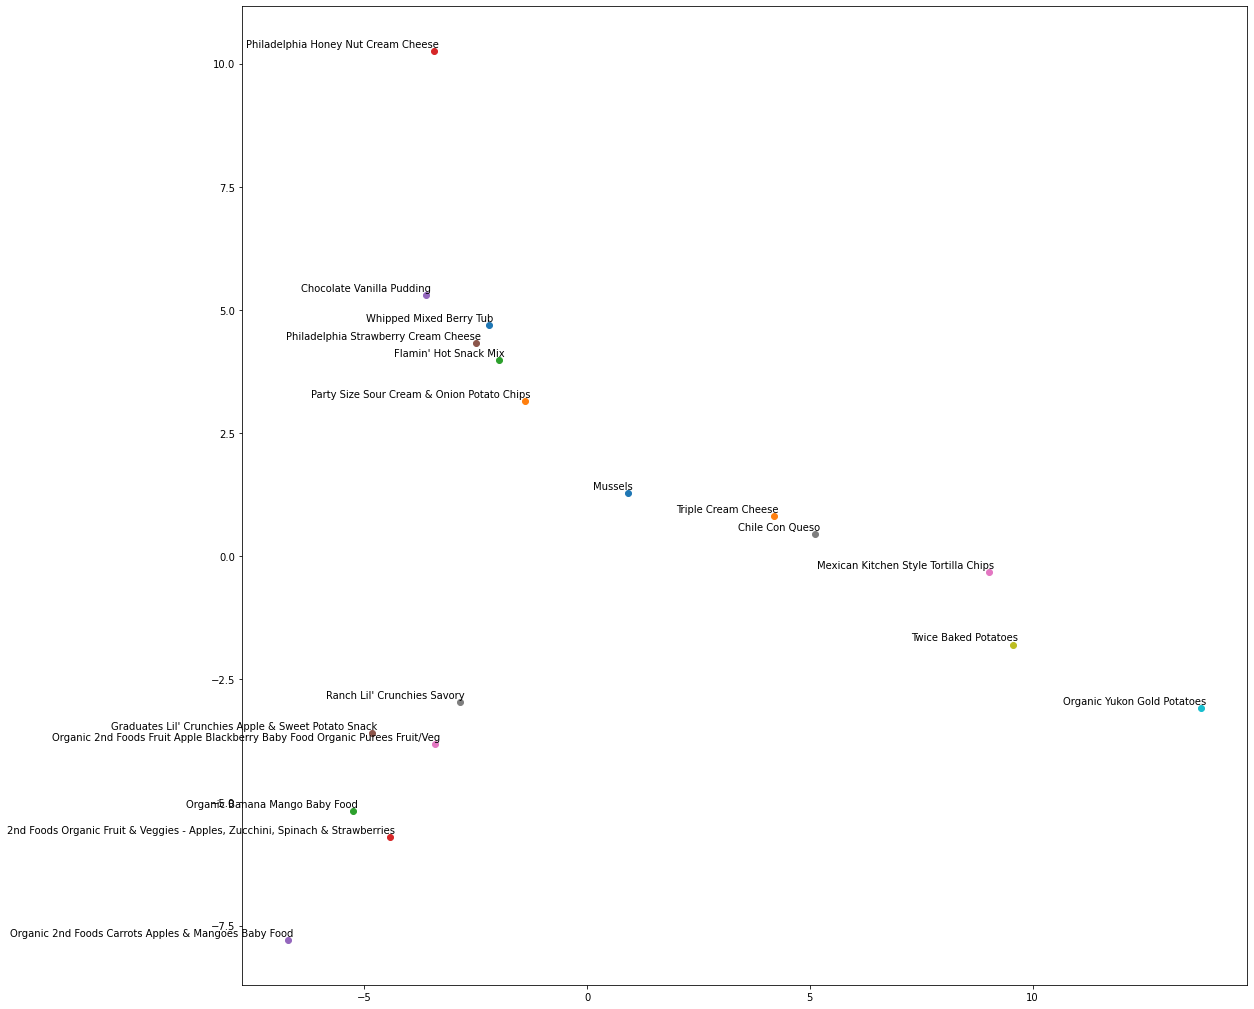

In [22]:
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=3):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)
embeds = pca.fit_transform(embeds)
plot_with_labels(embeds, labels)

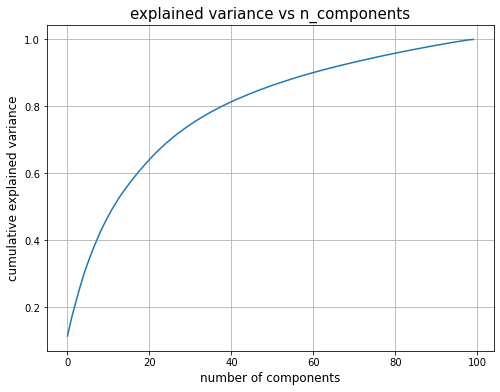

In [36]:
# Determine right number of components to project the data
pca = PCA()
pca.fit(model.wv[vocab])
plt.figure(figsize=(8,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("explained variance vs n_components",size=15)
plt.xlabel('number of components',size=12)
plt.ylabel('cumulative explained variance',size=12)
plt.grid()
plt.show()

From the above we can see that if we choose n_components=40 then we can preserve 80% of variance

In [10]:
pca = PCA(40)
pca.fit(model.wv[vocab])
print(pca.explained_variance_ratio_)
product2vec = pca.transform(model.wv[vocab])
product2vec = pd.DataFrame(product2vec)
product2vec.columns = ["pca_" + str(s) for s in product2vec.columns.tolist()]
product2vec["product_id"] = vocab
product2vec["product_id"] = product2vec["product_id"].astype(int)

[0.11489655 0.05394625 0.04585486 0.04405579 0.0409782  0.03460446
 0.03269333 0.02937479 0.02837744 0.02536833 0.02375031 0.02153355
 0.02001208 0.01904382 0.01709718 0.01643525 0.01587542 0.0152217
 0.01446342 0.0142141  0.01348808 0.01299151 0.01222539 0.01161546
 0.01125279 0.01042645 0.01000812 0.00947836 0.00896669 0.0088356
 0.00841552 0.00829066 0.00750434 0.00748793 0.00699786 0.00685448
 0.00646638 0.00640365 0.00620145 0.00558114]


In [3]:
# product2vec.to_pickle("product2vec.pkl")
product2vec = pd.read_pickle("product2vec.pkl")
#Merging with our data DF
data = data.merge(product2vec,on='product_id',how='left')
del product2vec
gc.collect()

0

In [15]:
data

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_avg_cart_position,uxp_add_to_cart_order_relative_mean,uxp_add_to_cart_order_inverted_mean,uxp_last_order_number,uxp_first_order_number,up_last_order_date,up_first_order_date,uxp_date_strike,uxp_order_strike,uxp_bought_last5,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_days_between_orders_std,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_total_unique_prod,u_basket_sum,u_avg_basket_size,u_basket_std,u_date_inscription,u_reorder_ratio_bool,u_tot_active_prod,p_total_purchases,p_reorder_ratio,p_avg_cart_position,p_unique_user_count,p_recency_order,p_recency_order_rev,p_recency_date,product_name,aisle_id,department_id,p_size,p_trend_rt,p_trend_diff,p_freq_days,p_freq_order,p_reorder_ratio_bool,p_tot_active_usr,uxa_total_unique_products,uxa_total_ordered,uxa_unique_products_ratio,a_total_purchases,a_reorder_ratio,...,a_unique_user_count,uxd_total_unique_products,uxd_total_ordered,uxd_unique_products_ratio,d_total_purchases,d_reorder_ratio,d_avg_cart_position,d_unique_user_count,a_reorder_ratio_bool,a_tot_active_user,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39
0,1,196,10,0.900000,1.400000,0.245278,4.500000,1,10,14.0,190.0,2.793540e-01,0.999023,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.900000,1.523884,190.0,0.555556,18,35791,0.776480,3.721774,8000,17.194993,17.089967,137.142354,Soda,77,7,2331.0,0.986876,-31.0,22.623835,2.372423,0.582500,8000,2,13,0.111111,357537,0.638832,...,63506,2,13,0.111111,2690129,0.653460,6.976699,172795,0.890367,172795,-10.814661,1.415145,0.037998,0.680587,2.825980,-2.091389,-3.517294,-0.145295,1.271382,-2.573950,-0.773742,-1.815776,2.270124,0.484873,-0.422418,-0.197900,-1.536030,0.039400,1.646057,0.028575,1.203125,1.737361,-1.891108,-0.787575,3.355452,-0.824200,-1.167430,-0.004780,1.771894,-1.454178,-2.236558,-0.665823,-1.114170,-0.034974,-1.021104,-0.579166,1.096577,-1.519546,-0.051071,0.331210
1,1,10258,9,0.888889,3.333333,0.562037,2.666667,1,9,14.0,175.0,2.793540e-01,0.998047,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.900000,1.523884,190.0,0.555556,18,1946,0.713772,4.277492,557,22.818602,13.091470,106.007708,Pistachios,117,19,152.0,1.041096,6.0,24.268539,2.858891,0.552962,557,1,9,0.055556,306487,0.519170,...,76177,4,22,0.222222,2887550,0.574180,9.187743,174219,0.888382,174219,0.750789,2.634611,-2.385622,-3.670125,-0.728006,0.380226,-0.222112,1.945072,-1.450704,-1.112153,-0.558545,-1.148836,-0.028298,-2.291514,2.671541,0.449566,0.870336,0.528781,0.311390,-1.970582,-2.117061,0.357748,-1.090221,-0.624520,0.235368,1.896098,1.448751,-2.155492,1.464124,-1.561112,-2.049346,-0.030342,-0.094427,-0.219296,-2.623412,0.785700,1.191588,0.285373,-0.830568,1.167473
2,1,10326,1,0.000000,5.000000,0.625000,3.000000,6,6,97.0,97.0,6.738828e-05,0.015625,0.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.900000,1.523884,190.0,0.555556,18,5526,0.652009,4.191097,1923,18.975932,12.014658,94.831705,Organic Fuji Apples,24,4,598.0,1.099265,54.0,26.605606,3.027755,0.521581,1923,4,5,0.222222,3642188,0.718104,...,177141,4,5,0.222222,9479291,0.649913,8.022875,193237,0.966326,193237,-2.070690,-0.966663,0.435931,-1.308307,-1.096418,-0.269507,2.836927,0.559602,-0.414527,-2.142804,-2.677059,-0.650725,-0.674264,-1.760494,1.677125,-0.307123,2.041259,-1.388001,-0.790728,0.646337,-2.491048,0.469695,-4.067341,-1.950205,-1.435372,3.374038,-2.538922,-0.472209,2.082766,-1.031404,-2.042576,2.662616,-0.417954,-2.338534,-4.013416,0.800738,2.258050,-0.637164,-2.289488,0.783615
3,1,12427,10,0.900000,3.300000,0.541667,2.600000,1,10,14.0,190.0,2.793540e-01,0.999023,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.900000,1.523884,190.0,0.555556,18,6476,0.740735,4.760037,1679,20.375540,18.812539,134.392063,Original Beef Jerky,23,19,3

# Create train and test DataFrames

In [8]:
# Till now we have user's behavior towards the product along with other features
orders = df_orders[(df_orders.eval_set=='train') | (df_orders.eval_set=='test')] # seleting train and test orders
# merging train/ test orders with our featurized user-product DF
data = data.merge(orders, on='user_id',how='left')
data_train = data[data.eval_set=='train']
# we will consider the reordered label as 0 for all the user-product combinations that are not there in train orders as they are not reordered in the latest order
data_train = data_train.merge(df_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train = data_train.drop(['order_id','eval_set'], axis=1)
#data_train = data_train.drop(['order_id','eval_set','days_since_prior_order','order_number'], axis=1)
#filling the NAN reordered values with 0.
data_train = data_train.fillna(0)
data_train.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_avg_cart_position,uxp_add_to_cart_order_relative_mean,uxp_add_to_cart_order_inverted_mean,uxp_last_order_number,uxp_first_order_number,up_last_order_date,up_first_order_date,uxp_date_strike,uxp_order_strike,uxp_bought_last5,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_days_between_orders_std,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_total_unique_prod,u_basket_sum,u_avg_basket_size,u_basket_std,u_date_inscription,u_reorder_ratio_bool,u_tot_active_prod,p_total_purchases,p_reorder_ratio,p_avg_cart_position,p_unique_user_count,p_recency_order,p_recency_order_rev,p_recency_date,product_name,aisle_id,department_id,p_size,p_trend_rt,p_trend_diff,p_freq_days,p_freq_order,p_reorder_ratio_bool,p_tot_active_usr,uxa_total_unique_products,uxa_total_ordered,uxa_unique_products_ratio,a_total_purchases,a_reorder_ratio,...,d_reorder_ratio,d_avg_cart_position,d_unique_user_count,a_reorder_ratio_bool,a_tot_active_user,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,order_number,order_dow,order_hour_of_day,days_since_prior_order,reordered
0,1,196,10,0.900000,1.400000,0.245278,4.500000,1,10,14.0,190.0,0.279354,0.999023,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.9,1.523884,190.0,0.555556,18,35791,0.776480,3.721774,8000,17.194993,17.089967,137.142354,Soda,77,7,2331.0,0.986876,-31.0,22.623835,2.372423,0.582500,8000,2,13,0.111111,357537,0.638832,...,0.653460,6.976699,172795,0.890367,172795,-10.814661,1.415145,0.037998,0.680587,2.825980,-2.091389,-3.517294,-0.145295,1.271382,-2.573950,-0.773742,-1.815776,2.270124,0.484873,-0.422418,-0.197900,-1.536030,0.039400,1.646057,0.028575,1.203125,1.737361,-1.891108,-0.787575,3.355452,-0.824200,-1.167430,-0.004780,1.771894,-1.454178,-2.236558,-0.665823,-1.114170,-0.034974,-1.021104,-0.579166,1.096577,-1.519546,-0.051071,0.331210,11,4,8,14.0,1.0
1,1,10258,9,0.888889,3.333333,0.562037,2.666667,1,9,14.0,175.0,0.279354,0.998047,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.9,1.523884,190.0,0.555556,18,1946,0.713772,4.277492,557,22.818602,13.091470,106.007708,Pistachios,117,19,152.0,1.041096,6.0,24.268539,2.858891,0.552962,557,1,9,0.055556,306487,0.519170,...,0.574180,9.187743,174219,0.888382,174219,0.750789,2.634611,-2.385622,-3.670125,-0.728006,0.380226,-0.222112,1.945072,-1.450704,-1.112153,-0.558545,-1.148836,-0.028298,-2.291514,2.671541,0.449566,0.870336,0.528781,0.311390,-1.970582,-2.117061,0.357748,-1.090221,-0.624520,0.235368,1.896098,1.448751,-2.155492,1.464124,-1.561112,-2.049346,-0.030342,-0.094427,-0.219296,-2.623412,0.785700,1.191588,0.285373,-0.830568,1.167473,11,4,8,14.0,1.0
2,1,10326,1,0.000000,5.000000,0.625000,3.000000,6,6,97.0,97.0,0.000067,0.015625,0.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.9,1.523884,190.0,0.555556,18,5526,0.652009,4.191097,1923,18.975932,12.014658,94.831705,Organic Fuji Apples,24,4,598.0,1.099265,54.0,26.605606,3.027755,0.521581,1923,4,5,0.222222,3642188,0.718104,...,0.649913,8.022875,193237,0.966326,193237,-2.070690,-0.966663,0.435931,-1.308307,-1.096418,-0.269507,2.836927,0.559602,-0.414527,-2.142804,-2.677059,-0.650725,-0.674264,-1.760494,1.677125,-0.307123,2.041259,-1.388001,-0.790728,0.646337,-2.491048,0.469695,-4.067341,-1.950205,-1.435372,3.374038,-2.538922,-0.472209,2.082766,-1.031404,-2.042576,2.662616,-0.417954,-2.338534,-4.013416,0.800738,2.258050,-0.637164,-2.289488,0.783615,11,4,8,14.0,0.0
3,1,12427,10,0.900000,3.300000,0.541667,2.600000,1,10,14.0,190.0,0.279354,0.999023,5.0,10,0.694915,20.259259,9.304463,4,7,59,18,59,5.9,1.523884,190.0,0.555556,18,6476,0.740735,4.760037,1679,20.375540,18.812539,134.392063,Original Beef Jerky,23,19,373.0,1.000000,0.0,19.953513,2.502397,0.529482,1679,2,12,0.111111,163524,0.591986,...,0.574180,9.187743,174

In [9]:
data_test = data[data.eval_set=='test']
data_test = data_test.fillna(0)
# data_test = data_test.drop(['eval_set', 'order_id','days_since_prior_order','order_number'], axis=1)
data_test = data_test.drop(['eval_set', 'order_id'], axis=1)
data_test.head()

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_avg_cart_position,uxp_add_to_cart_order_relative_mean,uxp_add_to_cart_order_inverted_mean,uxp_last_order_number,uxp_first_order_number,up_last_order_date,up_first_order_date,uxp_date_strike,uxp_order_strike,uxp_bought_last5,u_total_orders,u_reordered_ratio,u_average_days_between_orders,u_days_between_orders_std,u_dow_most_orders,u_hod_most_orders,u_total_items_bought,u_total_unique_prod,u_basket_sum,u_avg_basket_size,u_basket_std,u_date_inscription,u_reorder_ratio_bool,u_tot_active_prod,p_total_purchases,p_reorder_ratio,p_avg_cart_position,p_unique_user_count,p_recency_order,p_recency_order_rev,p_recency_date,product_name,aisle_id,department_id,p_size,p_trend_rt,p_trend_diff,p_freq_days,p_freq_order,p_reorder_ratio_bool,p_tot_active_usr,uxa_total_unique_products,uxa_total_ordered,uxa_unique_products_ratio,a_total_purchases,a_reorder_ratio,...,d_total_purchases,d_reorder_ratio,d_avg_cart_position,d_unique_user_count,a_reorder_ratio_bool,a_tot_active_user,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,pca_11,pca_12,pca_13,pca_14,pca_15,pca_16,pca_17,pca_18,pca_19,pca_20,pca_21,pca_22,pca_23,pca_24,pca_25,pca_26,pca_27,pca_28,pca_29,pca_30,pca_31,pca_32,pca_33,pca_34,pca_35,pca_36,pca_37,pca_38,pca_39,order_number,order_dow,order_hour_of_day,days_since_prior_order
120,3,248,1,0.000000,3.000000,0.333333,6.000000,11,11,135.0,135.0,0.000002,0.000488,0.0,12,0.625,11.487179,4.869048,0,16,88,33,88,7.333333,2.103388,144.0,0.575758,33,6371,0.400251,10.620782,3821,16.959818,18.417674,141.116936,Dried Sweetened Cranberries,117,19,383.0,1.010554,4.0,46.417255,6.323922,0.279508,3821,3,3,0.090909,306487,0.519170,...,2887550,0.574180,9.187743,174219,0.888382,174219,9.263702,-5.423434,0.685696,-0.840484,4.111034,3.692891,-3.079407,0.694447,-0.742594,-2.594401,1.284441,-0.117084,1.092660,-0.751215,0.607108,4.692741,-0.290782,0.223825,3.211171,-0.194267,-2.473917,1.322554,2.272155,1.814549,-1.618973,-1.738651,2.011090,-2.190995,0.352098,0.360861,-0.104296,-0.291801,-0.288057,0.631531,1.363197,1.692557,2.467378,1.467819,-2.676043,1.137368,13,5,15,11.0
121,3,1005,1,0.000000,5.000000,0.833333,1.000000,3,3,37.0,37.0,0.025635,0.125000,1.0,12,0.625,11.487179,4.869048,0,16,88,33,88,7.333333,2.103388,144.0,0.575758,33,463,0.440605,9.498920,259,20.393089,19.304536,135.382289,China Green Tips Green Tea,94,7,25.0,0.925926,-2.0,41.313725,6.480392,0.312741,259,1,1,0.030303,249341,0.527615,...,2690129,0.653460,6.976699,172795,0.890367,172795,1.480244,2.671022,-2.776263,0.044883,-2.696826,2.589295,-3.866552,0.658843,-3.379258,-4.100608,-2.204497,-1.454309,1.451594,0.967854,-0.135170,1.338621,-0.764218,-0.712892,1.627492,-0.303761,0.654195,-0.863049,-1.867740,0.244658,0.238718,1.388524,1.400556,-0.898713,-2.839363,-0.776960,-0.260028,0.432116,0.024790,0.144572,-0.634602,-0.932690,-0.206459,-0.931415,0.910613,-0.014540,13,5,15,11.0
122,3,1819,3,0.666667,2.666667,0.349074,4.666667,6,9,68.0,94.0,0.001876,0.025391,0.0,12,0.625,11.487179,4.869048,0,16,88,33,88,7.333333,2.103388,144.0,0.575758,33,2424,0.492162,9.287541,1231,19.483498,17.325495,124.964521,All Natural No Stir Creamy Almond Butter,88,13,149.0,0.943038,-9.0,34.731769,4.737636,0.346872,1231,2,4,0.060606,289400,0.487633,...,1875577,0.346721,9.593425,172755,0.868177,172755,4.093103,0.140579,-0.272116,1.578372,-2.030835,3.517858,3.589637,3.147690,0.957803,-4.172819,2.141769,1.709903,1.695943,1.578830,-0.877780,1.916400,1.154832,-2.019233,0.412602,-0.680321,-1.626999,-0.550549,-0.597845,0.230108,-1.043205,-1.882322,-1.254195,1.568598,2.030889,-1.207312,0.251188,0.104873,0.832810,2.737386,0.530929,0.198517,-0.462743,1.171521,-0.488636,1.449375,13,5,15,11.0
123,3,7503,1,0.000000,6.000000,1.000000,0.000000,10,10,114.0,114.0,0.000013,0.000977,0.0,12,0.625,11.487179,4.869048,0,16,88,33,88,7.333333,2.103388,144.0,0.575758,33,12474,0.553551,9.547379,5569,17.746914,17.697130,137.337262,Whole Almonds,117,19,756.0,1.032787,24.0,35.672266,4.57

## Encoding cyclic features

Here order_dow and order_hour_of_day are both cyclic features.
For order_dow the cycle repeats between 0 to 6 and for order_hour_of_day the cycle repeats between 0 to 23. There are certain problembs with cyclic features if we don't encode them properly. For example the difference between hour 23 and 22 is 1 but for hour 23 and 0 the difference is 23 although the real difference for both of them is 1 hour. We need to encode this cyclic features in such a way that hour 23 and 0 are close even though the absolute difference between them is 23.
<pre>One common way to encode cyclic features is to use sine an cosine transformations. 
We can do that using following transformation.
X<sub>sin</sub> = sin(2∗π∗x/max(x))
X<sub>cos</sub> = cos(2∗π∗x/max(x))
</pre>
Reference : http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

In [10]:
def encoding(values,max_val):
    '''
        This function returns sine and consine tranformation of 
        text(String) : input string
        Returns : 1 if  'organic' is substring of text
                  0 Otherwise
    '''
    x_sin = np.sin(2*np.pi*values/max_val)
    x_cos = np.cos(2*np.pi*values/max_val)
    return x_sin,x_cos

def get_cyclic_encoding(df):
    df['order_dow_sin'], df['order_dow_cos'] =   encoding(df['order_dow'],6) 
    # 6 is the maximum value for order_dow and 23 is the maximum value for order_dow
    df['order_hour_of_day_sin'], df['order_hour_of_day_cos'] = encoding(df['order_hour_of_day'],23)
    df.drop(['order_dow','order_hour_of_day'],axis=1,inplace=True) # dropping original features as we don't need them
    #filling NaN values with 0 
    df = df.fillna(0)
    return df

## Whether a product is Organic or not

We have Seen that people are more likely to reorder organic products. So we re adding a flag which indicates if a product is organic or not

In [11]:
def is_organic(text):
    '''
    This function whether 'organic' is substring of text or not
    Parameters:
    text(String) : input string
    Returns : 1 if  'organic' is substring of text
              0 Otherwise
    '''
    if 'organic' in str(text).lower():
        return 1
    else:
        return 0

In [12]:
del data, orders,df_orders,df_train

In [13]:
data_train = get_cyclic_encoding(data_train)
data_train['is_organic'] = data_train['product_name'].apply(is_organic)
data_test = get_cyclic_encoding(data_test)
data_test['is_organic'] = data_test['product_name'].apply(is_organic)
# Dropping product_name
data_train.drop(['product_name'],axis=1,inplace=True)
data_test.drop(['product_name'],axis=1,inplace=True)

In [14]:
# del data, orders,df_orders,df_train
gc.collect()
# Set user_id and product_id as the index of train/test DF
data_train = data_train.set_index(['user_id', 'product_id'])
data_test = data_test.set_index(['user_id', 'product_id'])

In [15]:
! rm data_train.pkl
! rm data_test.pkl

In [2]:
# data_train.to_pickle("data_train.pkl")
# data_test.to_pickle("data_test.pkl")
data_train  = pd.read_pickle("data_train.pkl")
data_test = pd.read_pickle("data_test.pkl")

In [ ]:
print(data_train.p_unique_user_count.max())
data_train.p_unique_user_count.min()

73956


1

In [14]:
data_train.days_since_prior_order.max()

30.0

In [12]:
data_train.dtypes
#data_test.drop(['product_name'],axis=1,inplace=True)

uxp_total_bought                         int64
uxp_reorder_ratio                      float64
uxp_avg_cart_position                  float64
uxp_add_to_cart_order_relative_mean    float64
uxp_add_to_cart_order_inverted_mean    float64
                                        ...   
order_dow_sin                          float64
order_dow_cos                          float64
order_hour_of_day_sin                  float64
order_hour_of_day_cos                  float64
is_organic                               int64
Length: 66, dtype: object

In [ ]:
column_dtypes = {
                 'uxp_total_bought' : np.uint8,
                 'uxp_reorder_ratio' :  np.float32,
                 'uxp_avg_cart_position': np.float32,
                 'uxp_bought_last5'  :   np.float16,
                 'u_total_orders' : np.uint8,
                 'u_reordered_ratio' : np.float32,
                 'u_average_days_between_orders' : np.float16,
                 'u_days_between_orders_std' : np.float32,
                 'u_dow_most_orders' : np.uint8,
                 'u_hod_most_orders' : np.uint8,
                 'u_total_items_bought' : np.uint32,
                 'u_avg_basket_size' : np.float16,
                 'p_total_purchases' : np.uint32,
                 'p_reorder_ratio' : np.float16,
                 'p_avg_cart_position' : np.float32,
                 'reordered' : np.uint8,
                 'order_dow_cos' : float,
                 'order_dow_sin' : float,
                'order_hour_of_day_sin' : float,
                'order_hour_of_day_cos' : float,
                 'is_organic' : np.uint8,
                 'product_name' : str,
                 'u_dow_most_orders' : np.uint8,
                 'u_hod_most_orders' :  np.uint8,
                 'u_total_unique_prod' :  np.uint16,
                 'u_basket_sum' :  np.uint32,
                 'u_basket_std' : np.float32,
                 'p_avg_cart_position': np.float32,
                 'p_unique_user_count' : np.uint32
                }
for col in data_train.columns:
    data_train[col] = data_train[col].astype(column_dtypes[col])
for col in data_test.columns:
    data_test[col] = data_test[col].astype(column_dtypes[col])

In [3]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()
    

In [9]:
# Reference : https://lightgbm.readthedocs.io/en/latest/Python-Intro.html
import warnings
warnings.filterwarnings('ignore')
estimator  = lgb.LGBMClassifier()
# Hyperparameter grid
parameters = {
    'class_weight': [None, 'balanced'],
    'early_stopping_round' : [50,100],
    'boosting_type': ['gbdt'],
    'num_leaves': list(range(30, 150)),
    'learning_rate': list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10))
}
random_search = RandomizedSearchCV(estimator,param_distributions=parameters,scoring = 'neg_log_loss',
                                   n_jobs = 4, cv = 3,
                            verbose=True,n_iter=50,random_state=25) #neg_log_loss f1
random_search.fit(data_train.drop(['reordered'], axis=1),data_train.reordered)
random_search.best_estimator_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.

The exit codes of the workers are {SIGKILL(-9)}

In [10]:

X = data_train.drop(['reordered'], axis=1)
y = data_train.reordered
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

lgbm = lgb.LGBMClassifier(colsample_bytree=0.8222222222222222,
               learning_rate=0.11283975359861685, max_depth=10,
               min_child_samples=435, num_leaves=96,
               reg_alpha=0.7551020408163265, reg_lambda=1.0,
               subsample_for_bin=160000,n_jobs =-1)

#fitting the model.
lgbm.fit(X_train, y_train)

#prediction
y_pred = (lgbm.predict_proba(X_test)[:, 1] >= 0.22).astype('int') #setting a threshold. I have tried different values and obsered 0.22 works best on the CV data
# Reference : https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/34977

#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))

F1 Score: 0.45040748781095413


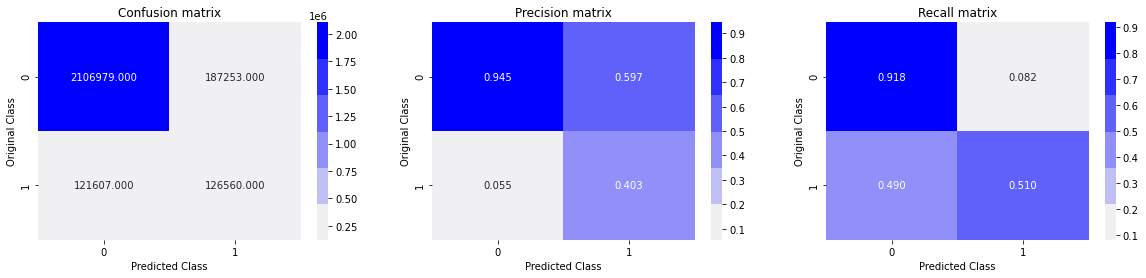

In [11]:
plot_confusion_matrix(y_test, y_pred)

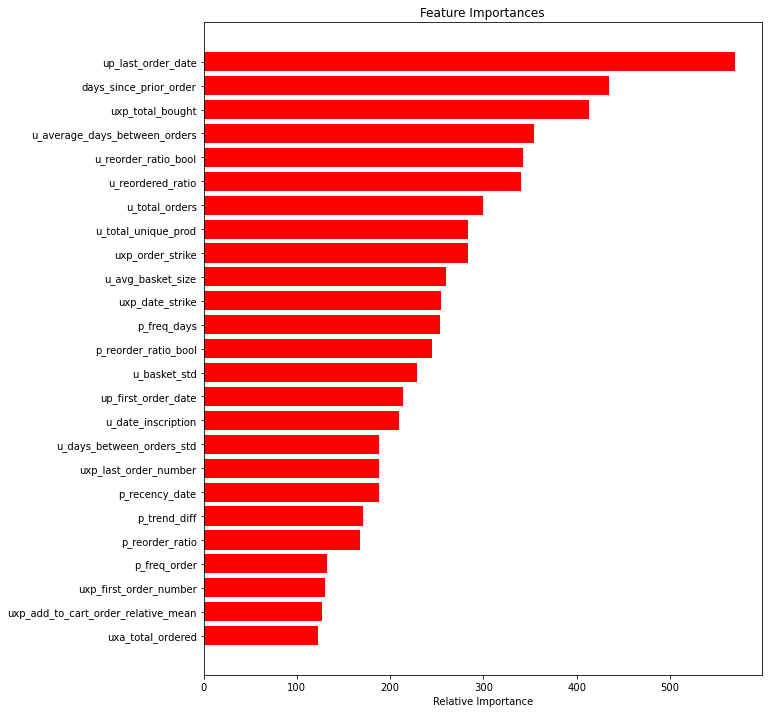

In [13]:
features = X_train.columns
importances = lgbm.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [5]:
#Fitting on entire data.
lgbm = lgb.LGBMClassifier(colsample_bytree=0.8222222222222222,
               learning_rate=0.11283975359861685, max_depth=10,
               min_child_samples=435, num_leaves=96,
               reg_alpha=0.7551020408163265, reg_lambda=1.0,
               subsample_for_bin=160000,n_jobs =-1)
lgbm.fit(data_train.drop(['reordered'], axis=1), data_train.reordered)

LGBMClassifier(colsample_bytree=0.8222222222222222,
               learning_rate=0.11283975359861685, max_depth=10,
               min_child_samples=435, num_leaves=96,
               reg_alpha=0.7551020408163265, reg_lambda=1.0,
               subsample_for_bin=160000)

In [7]:
#making prdeictions on the test dataset
y_pred_test = (lgbm.predict_proba(data_test)[:, 1] >= 0.22).astype('int') #setting a threshold.
#saving the prediction as a new column in data_test
data_test['prediction'] = y_pred_test
data_test.head()

ValueError: Number of features of the model must match the input. Model n_features_ is 105 and input n_features is 106 

In [8]:
# Reset the index
final = data_test.reset_index()
# Keep only the required columns to create our submission file 
final = final[['product_id', 'user_id', 'prediction']]

gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [11]:
orders_test = df_orders.loc[df_orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845


In [12]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()


,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [13]:
#remove user_id column
final = final.drop('user_id', axis=1)
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
del orders_test
gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568


In [14]:
! rm submission.csv

In [15]:
d = dict()
for row in final.itertuples():
    if row.prediction== 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)
# If no product is predicted for a particular order_id then we will predict None
for order in final.order_id:
    if order not in d:
        d[order] = 'None'
        
gc.collect()

40

In [16]:
#Convert the dictionary into a DataFrame
sub = pd.DataFrame.from_dict(d, orient='index')

#Reset index
sub.reset_index(inplace=True)
#Set column names
sub.columns = ['order_id', 'products']

sub.head()
sub.to_csv('submission.csv', index=False, header=True)

<img src="Capture.PNG" width="800" height="200">